<a name='1'></a>

# Table of contents
- [ 1 - Table of contents](#1)
    - [ 1.1 - Problem statement and tasks](#1.1)
    - [ 1.2 - Data description](#1.2)
    - [ 1.3 - References](#1.3)
- [ 2 - Imports](#2)
- [ 3 - Reading data](#3)
- [ 4 - EDA](#4)
    - [ 4.0.1 - SQL query for provider_id no show percentage](#4.0.1)
    - [ 4.0.2 - SQL query for sum of inf counts in each column](#4.0.2)        
    - [ 4.1 - Bivariate analysis numerical](#4.1)
    - [ 4.2 - Bivariate analysis categorical](#4.2)
        - [ 4.2.1 - SQL query for no show percentage for bookingslot](#4.0.1)
    - [ 4.3 - Correlation](#4.3)
- [ 5 - Feature engineering](#5)
    - [ 5.1 - Treating infinity values with median](#5.1)
    - [ 5.2 - Encoding booking slot](#5.2)
    - [ 5.3 - Train test split](#5.3)
    - [ 5.4 - Imbalanced treatment](#5.4)
        - [ 5.4.1 - Oversampling](#5.4.1)
        - [ 5.4.2 - Undersampling](#5.4.2)
        - [ 5.4.3 - SMOTE](#5.4.3)

- [ 6 - Feature selection](#6)
    - [ 6.1 - Final data](#6.1)
- [ 7 - Model build](#7)
    - [ 7.1 - Compare base models](#7.1)
    - [ 7.2 - Compare datasets](#7.2)
    - [ 7.3 - Final model hypertuning](#7.3)
    - [ 7.4 - Thresholds, metrics](#7.4)  
 
 - [ 8 - Recommendations, next steps](#8)
  <a name='1.1'></a>
 ## Problem statement and tasks
A major pain-point for customers is non-arrival of professionals for their service without prior intimation, (called No-Show) and leads to a bad experience. In case  Accelerated prediction of No-Show enables the platform (Urban Company) to deploy additional strategies to re-assign the booking to another professional.
You need to build a predictive model to predict No-Show probability of a request
- Perform a comprehensive EDA (Ans: Section 4)
- Share additional relevant insights and visualizations, (Ans: Section 4) 
- The associated sql query for computing the same in a JUPYTER Notebook. (Ans: Section 4.0.1, 4.0.2, 4.2.1) 
- Build a predictive model to predict no-Show given the features described (Ans: Section 7) 
- Find the ideal threshold for prediction if , the benefit of a correct no-show prediction is 400, benefit of correctly predicting a no-show NOT happening is 0, cost of incorrectly predicting a booking as no-show is -200, cost of incorrectly predicting a booking as NOT no-show is -150 (Ans: Section 7.4) 

  
  
  
 ## Data description
- ns_count_1day - No shows done by the partner/provider in the last 1 day and last 1 month
- is_exclusive_lead - Is the shown lead exclusively shown to partner/provider or not
- responded_lead_1day - Number of leads responded to by the partner/provider in the last 1 day and month
- paf_count_1day -  Number of cancellations where the partner/provider was at fault
- delivered_lead - Number of leads successfully delivered by the partner/provider
- service_delivery -  ratio of deliveries to lead responded by the partner/provider
- acceptance rate - ratio of responded leads to number of shown leads to the partner/provider
- pro_rating -  Average Provider rating given by customers
- Total Income - Money earned by provider net of commission and expenses
- days_no_block - Days not blocked by the platform and available to work
- days_block -  Days blocked by the platform
- number_times_blocked - Number of time blocked in the last n days

  
 <a name='1.2'></a> 
 ## References
 
 - Similar problem in appointment booking in health services
 - Datasets usually in the ~120k 
 - % of no show around ~14%
 - Algorithms mainly used logistic regression ,boosting 
 - Majorly use undersampling in case of imbalanced data, when there is good amount of data
 - Avg no of variables in the final model was ~17, main variables - lead time, prev no show, distance ,patient age 
 - Important links
     - https://www.mdpi.com/2078-2489/13/11/507
     - https://bmchealthservres.biomedcentral.com/articles/10.1186/s12913-023-10418-6
     - https://www.nature.com/articles/s41746-022-00594-w

<a name='2'></a>
# Imports

In [1]:
# !pip uninstall scikit-learn --yes
# !pip uninstall imblearn --yes
# !pip install scikit-learn==1.2.2
# !pip install imblearn
# !pip install hyperopt

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',76)
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score,confusion_matrix,f1_score,classification_report
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import OrdinalEncoder
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import StratifiedKFold,GridSearchCV
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import matplotlib.pyplot as plt
import seaborn as sns


<a name='3'></a>
# Reading data

In [4]:
#loading the data
df = pd.read_csv('data_assignment.gz', compression='gzip')

<a name='4'></a>
# EDA

In [5]:
#data is imbalanced
df["ns"].value_counts(normalize="True")*100

ns
0    96.915742
1     3.084258
Name: proportion, dtype: float64

Since dataset is imbalanced( only ~3% of no shows), we should try out methods like oversampling, undersampling to adjust the classes in the target variable

In [6]:
#shape of the data
df.shape

(181859, 75)

In [7]:
#Checking the count and dataypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181859 entries, 0 to 181858
Data columns (total 75 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        181859 non-null  object 
 1   provider_id                     181859 non-null  object 
 2   is_exclusive_lead               181859 non-null  int64  
 3   bookingslot                     181859 non-null  object 
 4   ns_count_1day                   181859 non-null  int64  
 5   ns_count_3day                   181859 non-null  int64  
 6   ns_count_1week                  181859 non-null  int64  
 7   ns_count_1month                 181859 non-null  int64  
 8   ns_count_6month                 181859 non-null  int64  
 9   responded_lead_1day             181859 non-null  int64  
 10  responded_lead_3day             181859 non-null  int64  
 11  responded_lead_1week            181859 non-null  int64  
 12  responded_lead_1

In [8]:
#data has multiple categorical and categorical numerical values
df.head(10)

,order_id,provider_id,is_exclusive_lead,bookingslot,ns_count_1day,ns_count_3day,ns_count_1week,ns_count_1month,ns_count_6month,responded_lead_1day,responded_lead_3day,responded_lead_1week,responded_lead_1month,responded_lead_3month,responded_lead_6month,paf_count_1day,paf_count_3day,paf_count_1week,paf_count_1month,paf_count_6month,delivered_lead_1day,delivered_lead_3day,delivered_lead_1week,delivered_lead_1month,delivered_lead_3month,delivered_lead_6month,service_delivery_rate_1day,service_delivery_rate_3day,service_delivery_rate_1week,service_delivery_rate_1month,service_delivery_rate_3month,service_delivery_rate_6month,Acceptance_Rate_1DAY,Acceptance_Rate_3DAY,Acceptance_Rate_1WEEK,Acceptance_Rate_1MONTH,Acceptance_Rate_3MONTH,Acceptance_Rate_6MONTH,pro_rating_1day,pro_rating_3day,pro_rating_1week,pro_rating_1month,pro_rating_3month,pro_rating_6month,total_income_1day,total_income_3day,total_income_1week,total_income_1month,total_income_3month,total_income_6month,days_no_block_in_1day,days_block_in_1day,number_times_blocked_in_1day,days_no_block_in_3day,days_block_in_3day,number_times_blocked_in_3day,days_no_block_in_1week,days_block_in_1week,number_times_blocked_in_1week,days_no_block_in_1month,days_block_in_1month,number_times_blocked_in_1month,days_no_block_in_3month,days_block_in_3month,number_times_blocked_in_3month,days_no_block_in_6month,days_block_in_6month,number_times_blocked_in_6month,avg_order_value_1day,avg_order_value_3day,avg_order_value_1week,avg_order_value_1month,avg_order_value_3month,avg_order_value_6month,ns
0,62107eff2938da280068c2c9,5e37b5f496d3362500c710d4,0,AfterNoon,0,0,0,1,5,2,6,13,32,97,223,1,1,2,6,44,1,5,11,26,75,179,0.500000,0.833333,0.846154,0.812500,0.773196,0.802691,3.000000,1.500000,1.600000,1.517241,1.886076,1.899471,5.000000,5.00,4.875000,4.843750,4.793478,4.785714,306.139956,1877.392747,5087.570615,14710.611406,38404.455871,94234.582247,1,0,0,3,0,0,7,0,0,30,0,0,90,0,0,178,2,1,0.000000,157.833333,352.923077,479.406250,399.288660,363.672646,0
1,62107eff2938da280068c2c9,5e58e2df14f8c026008e454a,0,AfterNoon,0,0,0,1,4,2,7,15,66,161,310,1,2,3,10,76,1,5,12,56,130,234,0.500000,0.714286,0.800000,0.848485,0.807453,0.754839,2.500000,1.500000,2.000000,1.650000,1.676692,1.712500,5.000000,4.75,4.875000,4.725806,4.741667,4.745614,357.476152,2028.609741,5827.121124,22248.825965,52708.768094,98110.364274,1,0,0,3,0,0,7,0,0,30,0,0,90,0,0,180,0,0,372.000000,302.857143,382.400000,421.212121,384.906832,347.167742,0
2,62107eff2938da280068c2c9,5f7182270446792500c1005a,0,AfterNoon,0,0,1,1,1,3,5,10,35,97,212,2,3,4,7,36,1,2,6,28,79,176,0.333333,0.400000,0.600000,0.800000,0.814433,0.830189,1.000000,1.000000,1.000000,1.033333,1.087500,1.279330,4.500000,4.50,4.833333,4.900000,4.882353,4.739130,359.154094,776.514019,2779.203630,10287.248557,24786.740728,55636.160136,1,0,0,3,0,0,7,0,0,30,0,0,90,0,0,180,0,0,249.000000,149.400000,411.800000,339.971429,273.268041,225.731132,0
3,62107eff2938da280068c2c9,5f0c7eb39eb3c12500d7af80,0,AfterNoon,0,0,0,1,19,2,7,22,76,215,480,1,4,8,28,184,1,3,14,48,128,296,0.500000,0.428571,0.636364,0.631579,0.595349,0.616667,1.000000,1.200000,1.214286,1.250000,1.500000,1.692308,5.000000,5.00,5.000000,4.988636,4.995798,4.958929,424.799899,1421.109832,6113.908648,19690.453213,53846.316431,121950.264014,1,0,0,3,0,0,7,0,0,30,0,0,89,0,0,179,0,0,0.000000,406.285714,255.181818,342.552632,422.446512,386.900000,0
4,6210830ba014f82a00115ca2,59f8630a8378405d001603d0,0,AfterNoon,0,0,0,0,1,2,7,20,89,290,538,1,2,5,21,138,1,5,15,68,219,400,0.500000,0.714286,0.750000,0.764045,0.755172,0.743494,1.000000,1.200000,1.266667,1.208955,1.221198,1.189526,3.000000,4.00,4.714286,4.522727,4.632812,4.719136,41.890533,1015.611112,1728.688877,16299.584613,54323.306404,97842.801498,1,0,0,3,0,0,7,0,0,30,0,0,90,0,0,180,0,0,114.500000,162.428571,183.400000,186.033708,162.231034,169.665428,1
5,62108152bd8bee29008f4d86,5b9b94aaad5b3224004507b1,1,Evening,0,0,1,1,2,3,6,11,40,67,143,1,2,5,10,43,2,4,6,30,47,100,0.666667,0.666667,0.5454

In [9]:
#Checking count of order_id and provider_id
print(len(df.order_id.unique()))
print(len(df.provider_id.unique()))

122917
17065


In [10]:
#Checking distribution of provider_id
provider_df=df["provider_id"].value_counts(normalize="True")*100
provider_df

provider_id
6192610a19024728005d8176    0.139669
5efda4ec641bf72c0005345a    0.137469
5c29edc377129b21002d4c2d    0.137469
5cb188c017c63e240039e6da    0.126472
605ee9c03e30c92800cef1ce    0.124272
                              ...   
5e156642f8e90a2400de840c    0.000550
61285b28cac66a280057af91    0.000550
5f66084414420d2900070103    0.000550
5d8c8c66f5bad32600699580    0.000550
614cc3942ac96d2a00d31e44    0.000550
Name: proportion, Length: 17065, dtype: float64

Alot of providers with less share, this would not be useful variable to deep dive on

<a name='4.0.1'></a>

### SQL query for provider_id counts


In [11]:
query="""
SELECT
    provider_id,
    COUNT(*) AS count,
    (COUNT(*) * 100.0 / SUM(COUNT(*)) OVER ()) AS percentage
FROM
    df
GROUP BY
    provider_id;
    """

In [12]:
#Checking distrubution of order_id
df["order_id"].value_counts(normalize="True")*100

order_id
61f50b4814aadd28008d54d2    0.019246
61e9581240dcad280073d2be    0.015946
61f51a480afe9f2800b9fcfe    0.015946
61ce8c9121d9c72400870c56    0.014847
61b39226e2ff3725007d9cde    0.014847
                              ...   
61e8feaa12aa612a0078d3fe    0.000550
61e947ad8ebca026002c9d7f    0.000550
61e909768c6b642a00faadce    0.000550
61e8d2ca07d65f28007ff027    0.000550
61a653772b453d28004fe049    0.000550
Name: proportion, Length: 122917, dtype: float64

All values are unique, no deep dive required

In [13]:
#Checking the null values
df.isnull().sum()

order_id                          0
provider_id                       0
is_exclusive_lead                 0
bookingslot                       0
ns_count_1day                     0
ns_count_3day                     0
ns_count_1week                    0
ns_count_1month                   0
ns_count_6month                   0
responded_lead_1day               0
responded_lead_3day               0
responded_lead_1week              0
responded_lead_1month             0
responded_lead_3month             0
responded_lead_6month             0
paf_count_1day                    0
paf_count_3day                    0
paf_count_1week                   0
paf_count_1month                  0
paf_count_6month                  0
delivered_lead_1day               0
delivered_lead_3day               0
delivered_lead_1week              0
delivered_lead_1month             0
delivered_lead_3month             0
delivered_lead_6month             0
service_delivery_rate_1day        0
service_delivery_rate_3day  

No null values, hence no need for missing value treatment

In [14]:
#Checking the inf values
def count_inf(df):
    # Count infinity values in each column
    inf_counts = df.isin([float('inf'), -float('inf')]).sum()
    return inf_counts


inf=count_inf(df)
inf

order_id                             0
provider_id                          0
is_exclusive_lead                    0
bookingslot                          0
ns_count_1day                        0
ns_count_3day                        0
ns_count_1week                       0
ns_count_1month                      0
ns_count_6month                      0
responded_lead_1day                  0
responded_lead_3day                  0
responded_lead_1week                 0
responded_lead_1month                0
responded_lead_3month                0
responded_lead_6month                0
paf_count_1day                       0
paf_count_3day                       0
paf_count_1week                      0
paf_count_1month                     0
paf_count_6month                     0
delivered_lead_1day                  0
delivered_lead_3day                  0
delivered_lead_1week                 0
delivered_lead_1month                0
delivered_lead_3month                0
delivered_lead_6month    

Few inf values in a 3 columns, which can be treated by median to keep it simple

<a name='4.0.2'></a>

### SQL query for sum of inf counts in each column

In [15]:
Query="""
SELECT 
    SUM(CASE WHEN Acceptance_Rate_1DAY = INFINITY THEN 1 ELSE 0 END) + SUM(CASE WHEN Acceptance_Rate_1DAY = -INFINITY THEN 1 ELSE 0 END) AS Acceptance_Rate_1DAY,
    SUM(CASE WHEN Acceptance_Rate_3DAY = INFINITY THEN 1 ELSE 0 END) + SUM(CASE WHEN Acceptance_Rate_3DAY = -INFINITY THEN 1 ELSE 0 END) AS Acceptance_Rate_3DAY,
FROM 
    df;
"""

<a name='4.1'></a>
## Bivariate analysis numerical

In [16]:
#Creating bar chart for distribution analysis
def plot_horizontal_bar_chart(df,x):
    try:
        # Convert the DataFrame to a format suitable for plotting
        data = df[['bin', 'NoShow Percentage']].set_index('bin').squeeze()

        # Create the figure and axis objects
        fig, ax = plt.subplots(figsize=(5, 2))

        # Plot the horizontal bar chart
        data.plot(kind='barh', ax=ax)

        # Customize the plot
        ax.set_title(x, fontsize=16)
        ax.set_xlabel('Percentage', fontsize=14)
        ax.set_ylabel('Bin', fontsize=14)

        # Rotate x-axis labels for better visibility
        plt.suptitle('')
        plt.xticks(rotation=45)

        # Display the plot
        plt.show()
    
    except Exception as e:
        print("An error occurred:", e)
        pass  # Continue with the next plot




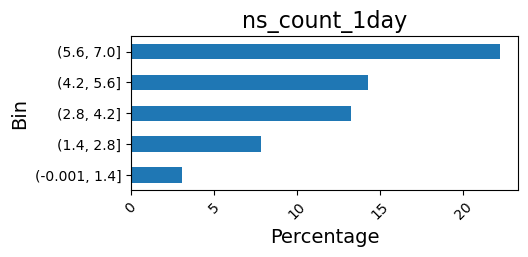

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 1.4]           180800             99.417681           3.052544
1     (1.4, 2.8]              945              0.519633           7.830688
2     (2.8, 4.2]               98              0.053888          13.265306
3     (4.2, 5.6]                7              0.003849          14.285714
4     (5.6, 7.0]                9              0.004949          22.222222 



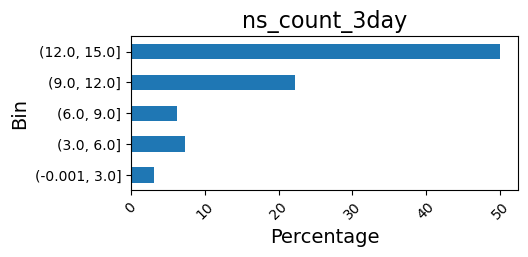

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 3.0]           180955             99.502912           3.062640
1     (3.0, 6.0]              603              0.331576           7.296849
2     (6.0, 9.0]              286              0.157265           6.293706
3    (9.0, 12.0]                9              0.004949          22.222222
4   (12.0, 15.0]                6              0.003299          50.000000 



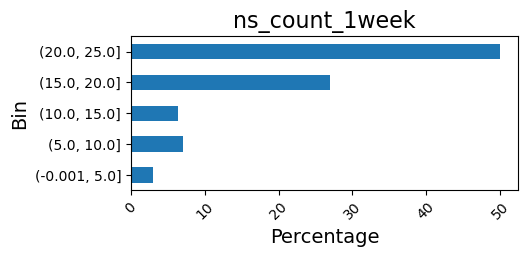

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 5.0]           180500             99.252718           3.051524
1    (5.0, 10.0]              873              0.480042           7.101947
2   (10.0, 15.0]              454              0.249644           6.387665
3   (15.0, 20.0]               26              0.014297          26.923077
4   (20.0, 25.0]                6              0.003299          50.000000 



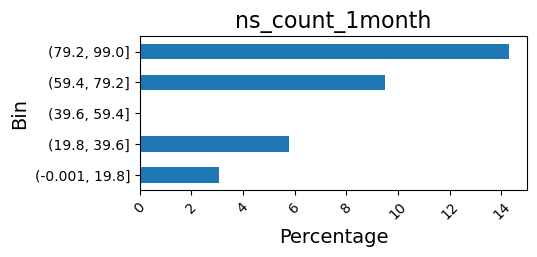

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 19.8]           180737             99.383039           3.063568
1    (19.8, 39.6]              936              0.514684           5.769231
2    (39.6, 59.4]                0              0.000000                NaN
3    (59.4, 79.2]              179              0.098428           9.497207
4    (79.2, 99.0]                7              0.003849          14.285714 



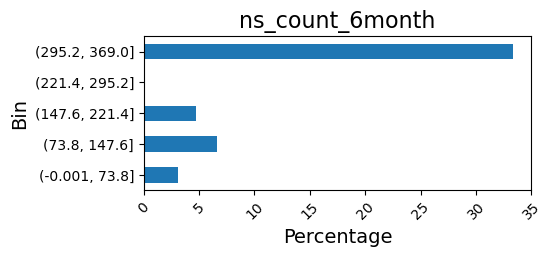

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 73.8]           180984             99.518858           3.068780
1   (73.8, 147.6]              451              0.247994           6.651885
2  (147.6, 221.4]              406              0.223250           4.679803
3  (221.4, 295.2]                0              0.000000                NaN
4  (295.2, 369.0]               18              0.009898          33.333333 



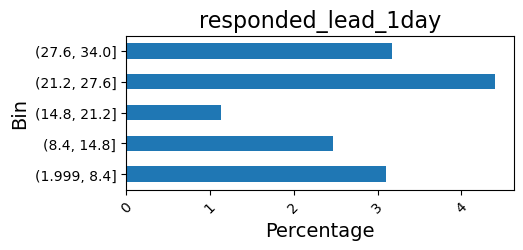

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (1.999, 8.4]           176446             97.023518           3.096131
1   (8.4, 14.8]             4500              2.474444           2.466667
2  (14.8, 21.2]               88              0.048389           1.136364
3  (21.2, 27.6]              636              0.349721           4.402516
4  (27.6, 34.0]              189              0.103927           3.174603 



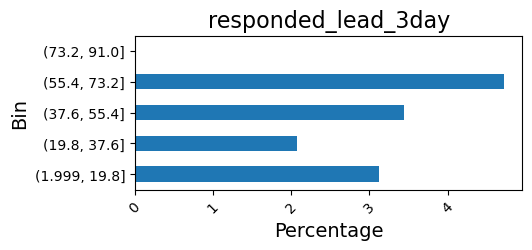

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (1.999, 19.8]           172874             95.059359           3.122505
1   (19.8, 37.6]             7671              4.218103           2.072741
2   (37.6, 55.4]              523              0.287585           3.441683
3   (55.4, 73.2]              720              0.395911           4.722222
4   (73.2, 91.0]               71              0.039041           0.000000 



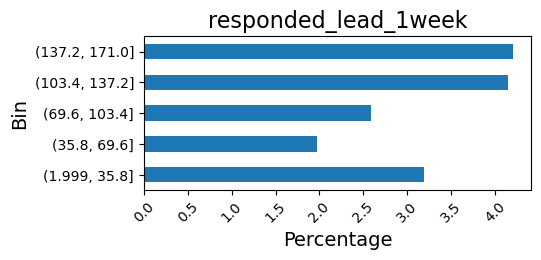

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0   (1.999, 35.8]           163507             89.908666           3.192524
1    (35.8, 69.6]            16991              9.342953           1.977518
2   (69.6, 103.4]              232              0.127571           2.586207
3  (103.4, 137.2]              772              0.424505           4.145078
4  (137.2, 171.0]              357              0.196306           4.201681 



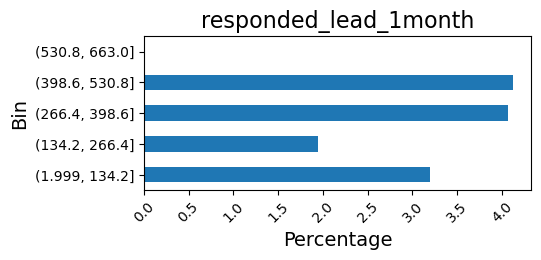

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (1.999, 134.2]           163606             89.963103           3.199149
1  (134.2, 266.4]            17291              9.507915           1.948991
2  (266.4, 398.6]              566              0.311230           4.063604
3  (398.6, 530.8]              364              0.200155           4.120879
4  (530.8, 663.0]               32              0.017596           0.000000 



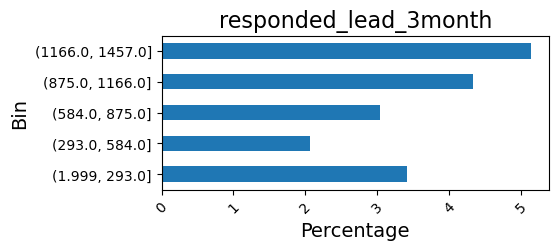

                bin  order_id Counts  order_id Percentages  NoShow Percentage
0    (1.999, 293.0]           135858             74.705129           3.416803
1    (293.0, 584.0]            44555             24.499750           2.060375
2    (584.0, 875.0]             1121              0.616412           3.033006
3   (875.0, 1166.0]              208              0.114374           4.326923
4  (1166.0, 1457.0]              117              0.064336           5.128205 



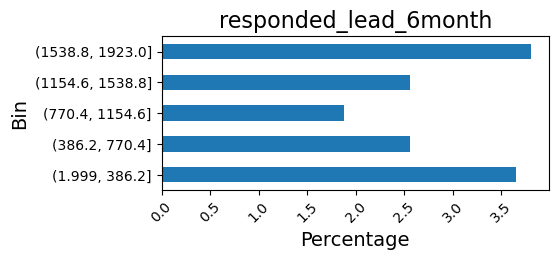

                bin  order_id Counts  order_id Percentages  NoShow Percentage
0    (1.999, 386.2]            95216             52.357046           3.657999
1    (386.2, 770.4]            71761             39.459691           2.557099
2   (770.4, 1154.6]            14083              7.743911           1.881701
3  (1154.6, 1538.8]              352              0.193557           2.556818
4  (1538.8, 1923.0]              447              0.245795           3.803132 



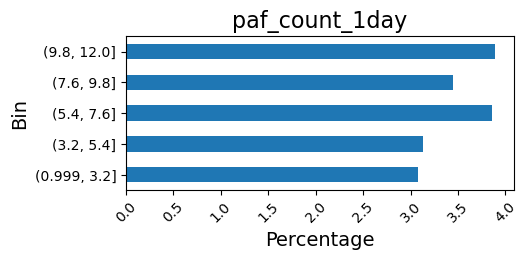

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 3.2]           174480             95.942461           3.076570
1    (3.2, 5.4]             6005              3.302009           3.130724
2    (5.4, 7.6]              908              0.499288           3.854626
3    (7.6, 9.8]               29              0.015946           3.448276
4   (9.8, 12.0]              437              0.240296           3.890160 



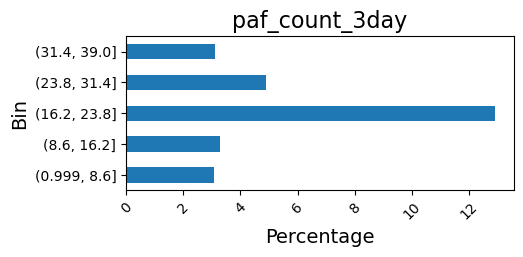

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 8.6]           177303             97.494762           3.073834
1   (8.6, 16.2]             3838              2.110426           3.282960
2  (16.2, 23.8]               31              0.017046          12.903226
3  (23.8, 31.4]              430              0.236447           4.883721
4  (31.4, 39.0]              257              0.141318           3.112840 



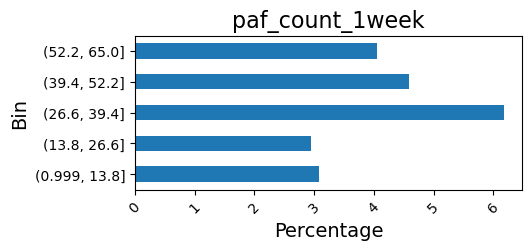

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 13.8]           172114             94.641453           3.078773
1   (13.8, 26.6]             8643              4.752583           2.950364
2   (26.6, 39.4]              421              0.231498           6.175772
3   (39.4, 52.2]              262              0.144068           4.580153
4   (52.2, 65.0]              419              0.230398           4.057279 



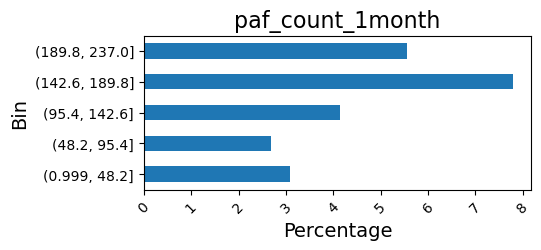

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0   (0.999, 48.2]           172542             94.876800           3.096058
1    (48.2, 95.4]             8498              4.672851           2.682984
2   (95.4, 142.6]              580              0.318928           4.137931
3  (142.6, 189.8]               77              0.042340           7.792208
4  (189.8, 237.0]              162              0.089080           5.555556 



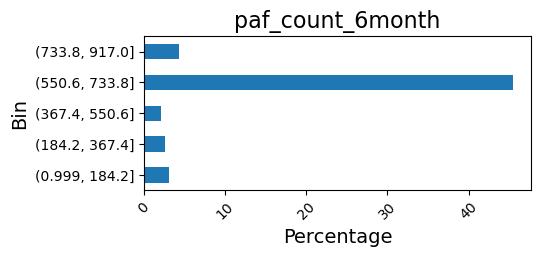

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 184.2]           155625             85.574539           3.158233
1  (184.2, 367.4]            24681             13.571503           2.625501
2  (367.4, 550.6]             1150              0.632358           2.086957
3  (550.6, 733.8]               11              0.006049          45.454545
4  (733.8, 917.0]              392              0.215552           4.336735 



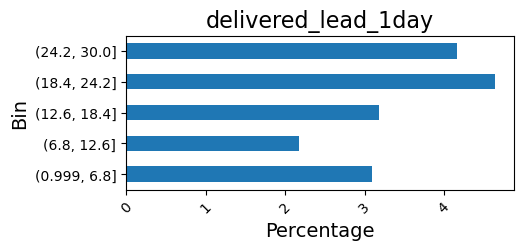

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 6.8]           177741             97.735608           3.098891
1   (6.8, 12.6]             3454              1.899274           2.171395
2  (12.6, 18.4]              283              0.155615           3.180212
3  (18.4, 24.2]              237              0.130321           4.641350
4  (24.2, 30.0]              144              0.079182           4.166667 



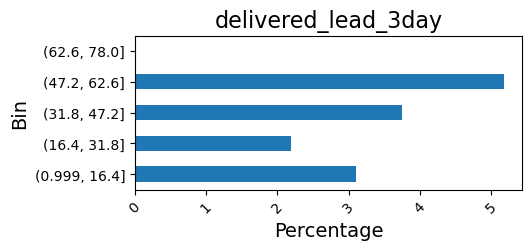

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 16.4]           176793             97.214325           3.101367
1   (16.4, 31.8]             4321              2.376017           2.198565
2   (31.8, 47.2]              373              0.205104           3.753351
3   (47.2, 62.6]              328              0.180360           5.182927
4   (62.6, 78.0]               44              0.024195           0.000000 



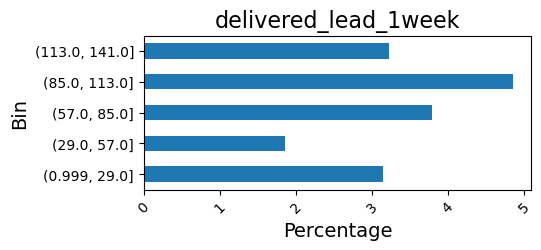

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0   (0.999, 29.0]           170342             93.667072           3.153069
1    (29.0, 57.0]            10445              5.743461           1.857348
2    (57.0, 85.0]              474              0.260641           3.797468
3   (85.0, 113.0]              412              0.226549           4.854369
4  (113.0, 141.0]              186              0.102277           3.225806 



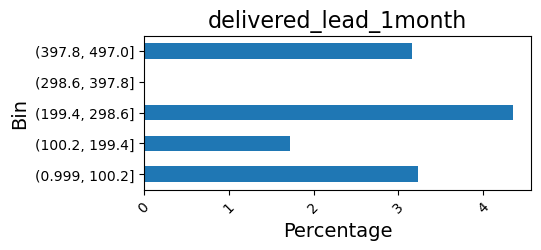

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 100.2]           163149             89.711810           3.227111
1  (100.2, 199.4]            17732              9.750411           1.725694
2  (199.4, 298.6]              736              0.404709           4.347826
3  (298.6, 397.8]               52              0.028594           0.000000
4  (397.8, 497.0]              190              0.104477           3.157895 



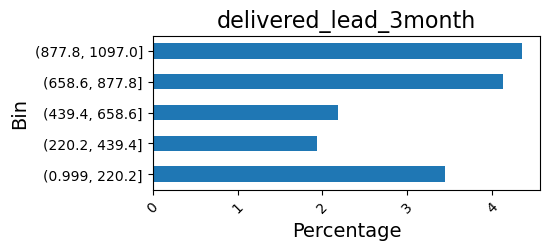

               bin  order_id Counts  order_id Percentages  NoShow Percentage
0   (0.999, 220.2]           138274             76.033630           3.440271
1   (220.2, 439.4]            42408             23.319165           1.935955
2   (439.4, 658.6]              918              0.504787           2.178649
3   (658.6, 877.8]              121              0.066535           4.132231
4  (877.8, 1097.0]              138              0.075883           4.347826 



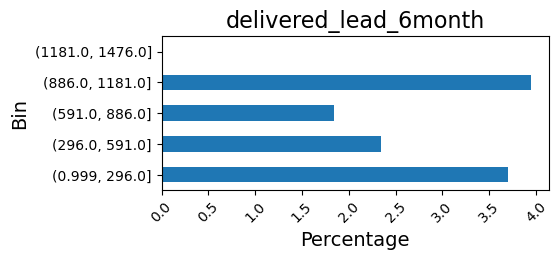

                bin  order_id Counts  order_id Percentages  NoShow Percentage
0    (0.999, 296.0]           102513             56.369495           3.706847
1    (296.0, 591.0]            66170             36.385331           2.348496
2    (591.0, 886.0]            12487              6.866309           1.841916
3   (886.0, 1181.0]              634              0.348622           3.943218
4  (1181.0, 1476.0]               55              0.030243           0.000000 



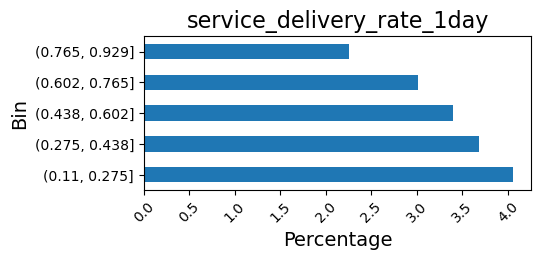

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0   (0.11, 0.275]             3280              1.803595           4.054878
1  (0.275, 0.438]            14565              8.008952           3.686921
2  (0.438, 0.602]            56576             31.109816           3.397200
3  (0.602, 0.765]            78903             43.386910           3.010025
4  (0.765, 0.929]            28535             15.690727           2.249869 



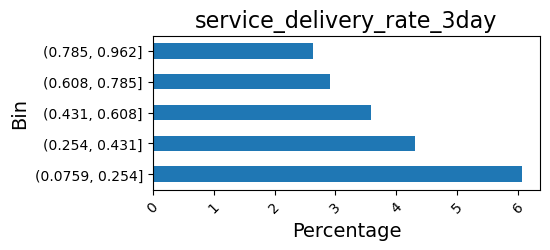

               bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.0759, 0.254]             1899              1.044216           6.055819
1   (0.254, 0.431]            10042              5.521860           4.301932
2   (0.431, 0.608]            39775             21.871340           3.587681
3   (0.608, 0.785]            79082             43.485338           2.902051
4   (0.785, 0.962]            51061             28.077247           2.624312 



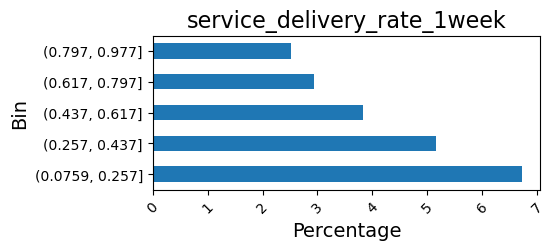

               bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.0759, 0.257]             1042              0.572971           6.717850
1   (0.257, 0.437]             5970              3.282763           5.159129
2   (0.437, 0.617]            33271             18.294943           3.820144
3   (0.617, 0.797]            92176             50.685421           2.943282
4   (0.797, 0.977]            49400             27.163902           2.524291 



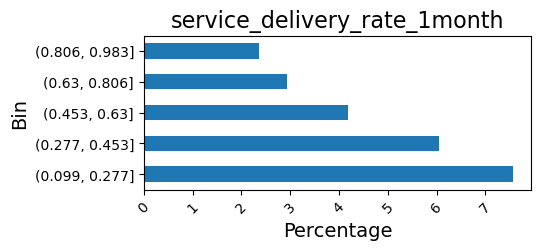

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.099, 0.277]              582              0.320028           7.560137
1  (0.277, 0.453]             3605              1.982305           6.047157
2   (0.453, 0.63]            28769             15.819399           4.192012
3   (0.63, 0.806]           108772             59.811172           2.936417
4  (0.806, 0.983]            40131             22.067096           2.359772 



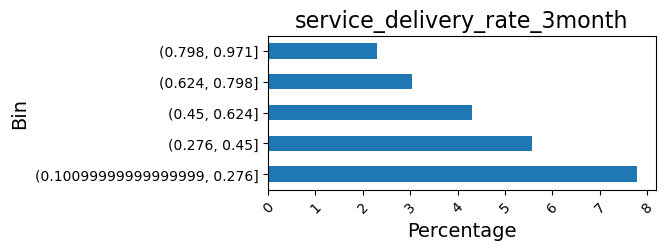

                            bin  order_id Counts  order_id Percentages  \
0  (0.10099999999999999, 0.276]              334              0.183659   
1                 (0.276, 0.45]             2911              1.600691   
2                 (0.45, 0.624]            22867             12.574027   
3                (0.624, 0.798]           114457             62.937221   
4                (0.798, 0.971]            41290             22.704403   

   NoShow Percentage  
0           7.784431  
1           5.565098  
2           4.307517  
3           3.046559  
4           2.298377   



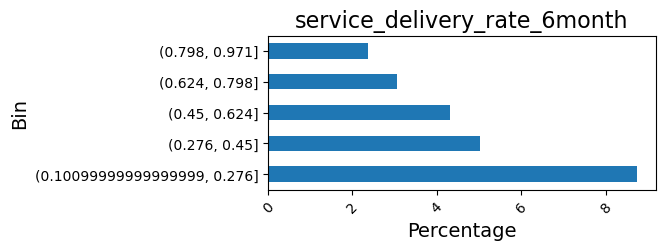

                            bin  order_id Counts  order_id Percentages  \
0  (0.10099999999999999, 0.276]              206              0.113275   
1                 (0.276, 0.45]             2431              1.336750   
2                 (0.45, 0.624]            21048             11.573802   
3                (0.624, 0.798]           119673             65.805377   
4                (0.798, 0.971]            38501             21.170797   

   NoShow Percentage  
0           8.737864  
1           5.018511  
2           4.304447  
3           3.049142  
4           2.373964   



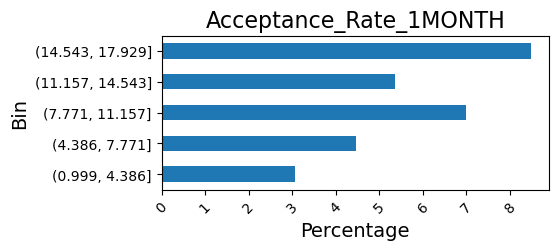

                bin  order_id Counts  order_id Percentages  NoShow Percentage
0    (0.999, 4.386]           179574             98.743532           3.062247
1    (4.386, 7.771]             1970              1.083257           4.467005
2   (7.771, 11.157]              200              0.109975           7.000000
3  (11.157, 14.543]               56              0.030793           5.357143
4  (14.543, 17.929]               59              0.032443           8.474576 



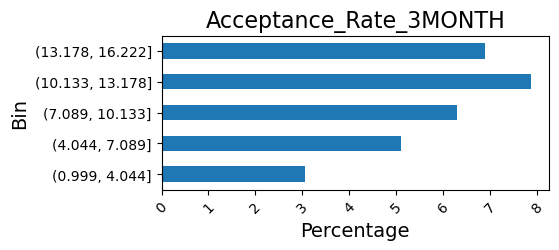

                bin  order_id Counts  order_id Percentages  NoShow Percentage
0    (0.999, 4.044]           179347             98.618710           3.052184
1    (4.044, 7.089]             2060              1.132746           5.097087
2   (7.089, 10.133]              334              0.183659           6.287425
3  (10.133, 13.178]               89              0.048939           7.865169
4  (13.178, 16.222]               29              0.015946           6.896552 



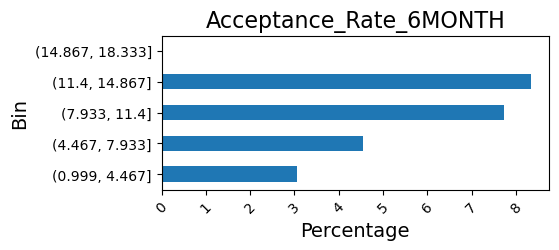

                bin  order_id Counts  order_id Percentages  NoShow Percentage
0    (0.999, 4.467]           180395             99.194981           3.068267
1    (4.467, 7.933]             1206              0.663151           4.560531
2     (7.933, 11.4]              207              0.113824           7.729469
3    (11.4, 14.867]               36              0.019796           8.333333
4  (14.867, 18.333]               15              0.008248           0.000000 



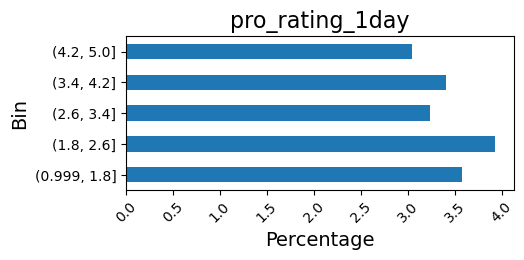

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 1.8]             2093              1.150892           3.583373
1    (1.8, 2.6]             1577              0.867155           3.931516
2    (2.6, 3.4]             3364              1.849785           3.240190
3    (3.4, 4.2]             9873              5.428931           3.413350
4    (4.2, 5.0]           164952             90.703237           3.046947 



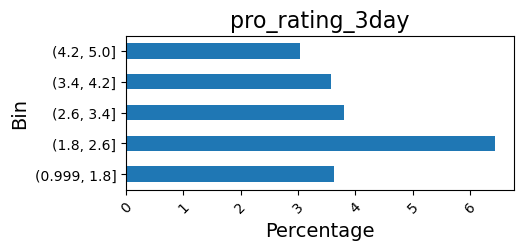

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 1.8]              468              0.257342           3.632479
1    (1.8, 2.6]              404              0.222150           6.435644
2    (2.6, 3.4]             2809              1.544603           3.809185
3    (3.4, 4.2]            11885              6.535283           3.575936
4    (4.2, 5.0]           166293             91.440622           3.027187 



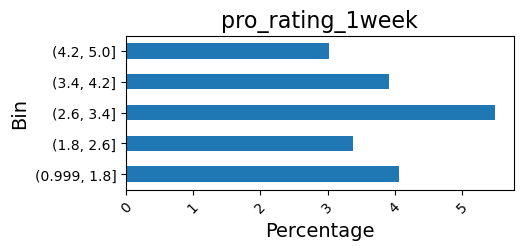

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 1.8]              148              0.081382           4.054054
1    (1.8, 2.6]              178              0.097878           3.370787
2    (2.6, 3.4]             1111              0.610913           5.490549
3    (3.4, 4.2]             9294              5.110553           3.905746
4    (4.2, 5.0]           171128             94.099275           3.022883 



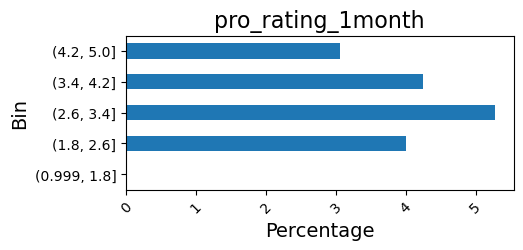

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 1.8]                1              0.000550           0.000000
1    (1.8, 2.6]               25              0.013747           4.000000
2    (2.6, 3.4]              379              0.208403           5.277045
3    (3.4, 4.2]             2782              1.529757           4.241553
4    (4.2, 5.0]           178672             98.247543           3.061476 



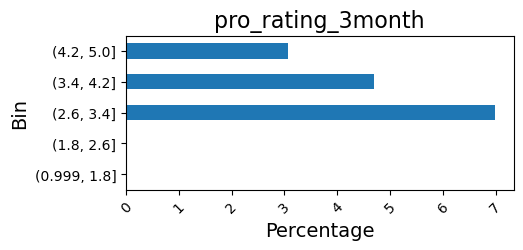

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 1.8]                1              0.000550           0.000000
1    (1.8, 2.6]                4              0.002200           0.000000
2    (2.6, 3.4]              186              0.102277           6.989247
3    (3.4, 4.2]             1681              0.924342           4.699584
4    (4.2, 5.0]           179987             98.970631           3.065221 



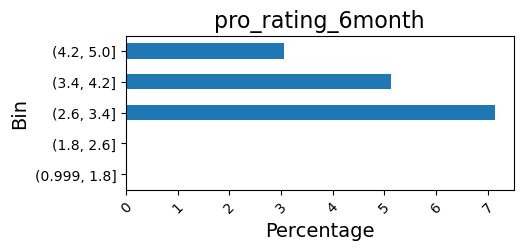

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 1.8]                1              0.000550           0.000000
1    (1.8, 2.6]                0              0.000000                NaN
2    (2.6, 3.4]              168              0.092379           7.142857
3    (3.4, 4.2]             1229              0.675798           5.126119
4    (4.2, 5.0]           180461             99.231273           3.066591 



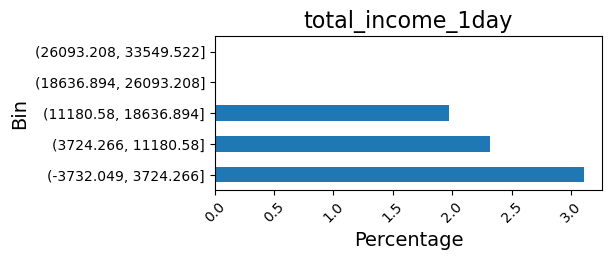

                      bin  order_id Counts  order_id Percentages  \
0   (-3732.049, 3724.266]           176358             96.975129   
1    (3724.266, 11180.58]             5300              2.914346   
2   (11180.58, 18636.894]              152              0.083581   
3  (18636.894, 26093.208]               38              0.020895   
4  (26093.208, 33549.522]               11              0.006049   

   NoShow Percentage  
0           3.109017  
1           2.320755  
2           1.973684  
3           0.000000  
4           0.000000   



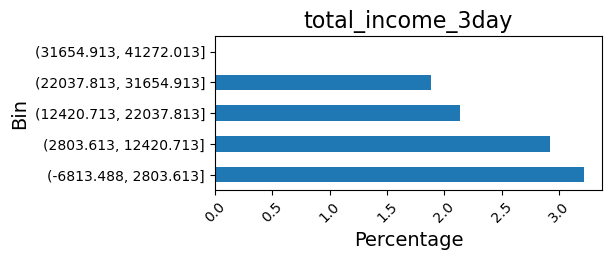

                      bin  order_id Counts  order_id Percentages  \
0   (-6813.488, 2803.613]           107763             59.256347   
1   (2803.613, 12420.713]            72476             39.852853   
2  (12420.713, 22037.813]             1406              0.773126   
3  (22037.813, 31654.913]              159              0.087430   
4  (31654.913, 41272.013]               55              0.030243   

   NoShow Percentage  
0           3.213533  
1           2.915448  
2           2.133713  
3           1.886792  
4           0.000000   



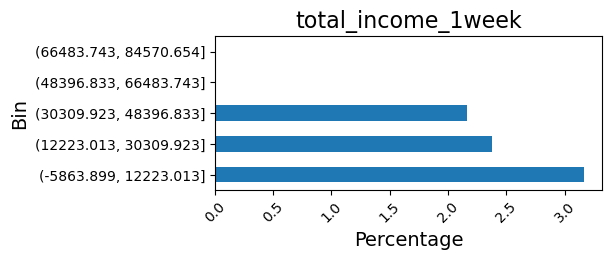

                      bin  order_id Counts  order_id Percentages  \
0  (-5863.899, 12223.013]           164383             90.390357   
1  (12223.013, 30309.923]            16692              9.178539   
2  (30309.923, 48396.833]              647              0.355770   
3  (48396.833, 66483.743]              131              0.072034   
4  (66483.743, 84570.654]                6              0.003299   

   NoShow Percentage  
0           3.162736  
1           2.372394  
2           2.163833  
3           0.000000  
4           0.000000   



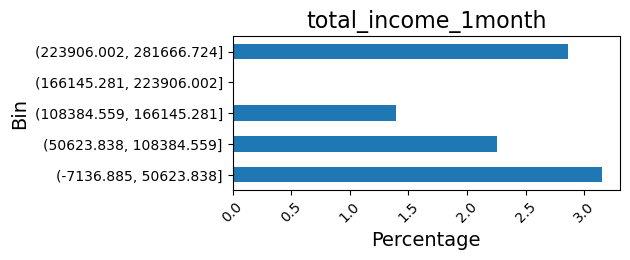

                        bin  order_id Counts  order_id Percentages  \
0    (-7136.885, 50623.838]           170061             93.512556   
1   (50623.838, 108384.559]            10987              6.041494   
2  (108384.559, 166145.281]              646              0.355220   
3  (166145.281, 223906.002]              130              0.071484   
4  (223906.002, 281666.724]               35              0.019246   

   NoShow Percentage  
0           3.146518  
1           2.257213  
2           1.393189  
3           0.000000  
4           2.857143   



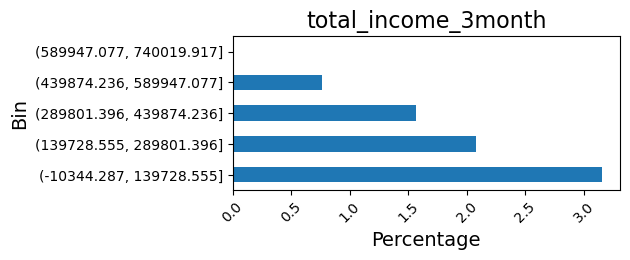

                        bin  order_id Counts  order_id Percentages  \
0  (-10344.287, 139728.555]           170930             93.990399   
1  (139728.555, 289801.396]            10058              5.530658   
2  (289801.396, 439874.236]              702              0.386013   
3  (439874.236, 589947.077]              131              0.072034   
4  (589947.077, 740019.917]               38              0.020895   

   NoShow Percentage  
0           3.152168  
1           2.077948  
2           1.566952  
3           0.763359  
4           0.000000   



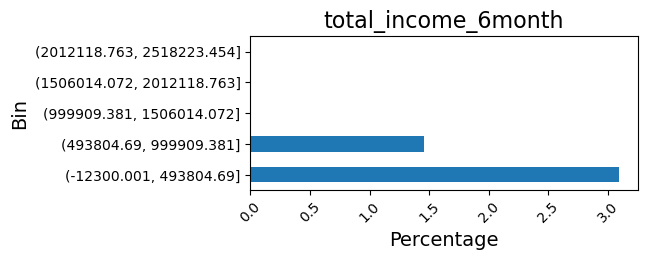

                          bin  order_id Counts  order_id Percentages  \
0     (-12300.001, 493804.69]           180702             99.363793   
1     (493804.69, 999909.381]             1099              0.604314   
2   (999909.381, 1506014.072]               51              0.028044   
3  (1506014.072, 2012118.763]                0              0.000000   
4  (2012118.763, 2518223.454]                7              0.003849   

   NoShow Percentage  
0           3.095151  
1           1.455869  
2           0.000000  
3                NaN  
4           0.000000   



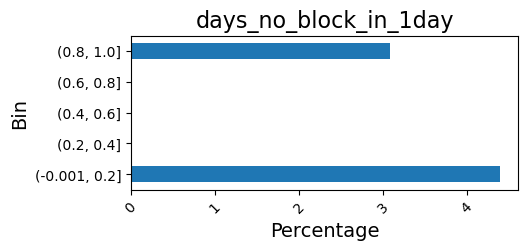

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 0.2]              364              0.200155           4.395604
1     (0.2, 0.4]                0              0.000000                NaN
2     (0.4, 0.6]                0              0.000000                NaN
3     (0.6, 0.8]                0              0.000000                NaN
4     (0.8, 1.0]           181495             99.799845           3.081628 



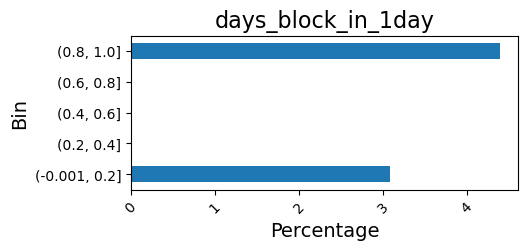

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 0.2]           181495             99.799845           3.081628
1     (0.2, 0.4]                0              0.000000                NaN
2     (0.4, 0.6]                0              0.000000                NaN
3     (0.6, 0.8]                0              0.000000                NaN
4     (0.8, 1.0]              364              0.200155           4.395604 

An error occurred: index 0 is out of bounds for axis 0 with size 0
Empty DataFrame
Columns: [bin, order_id Counts, order_id Percentages, NoShow Percentage]
Index: [] 



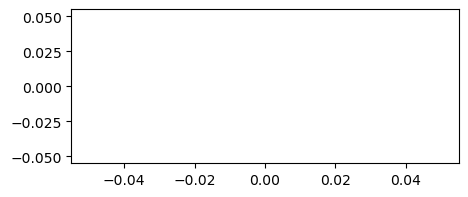

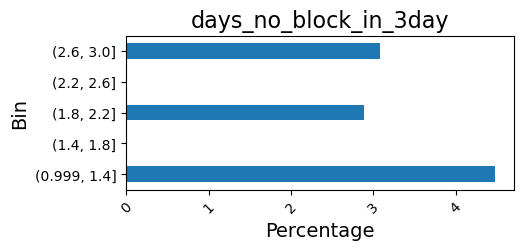

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 1.4]             1028              0.565273           4.474708
1    (1.4, 1.8]                0              0.000000                NaN
2    (1.8, 2.2]             3194              1.756306           2.880401
3    (2.2, 2.6]                0              0.000000                NaN
4    (2.6, 3.0]           177637             97.678421           3.079876 



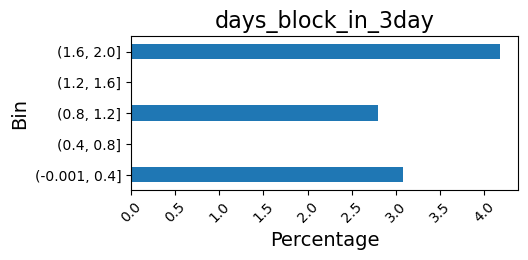

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 0.4]           178023             97.890674           3.083871
1     (0.4, 0.8]                0              0.000000                NaN
2     (0.8, 1.2]             2974              1.635333           2.790854
3     (1.2, 1.6]                0              0.000000                NaN
4     (1.6, 2.0]              862              0.473994           4.176334 



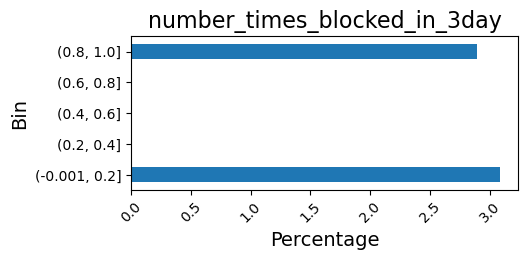

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 0.2]           180995             99.524907           3.085168
1     (0.2, 0.4]                0              0.000000                NaN
2     (0.4, 0.6]                0              0.000000                NaN
3     (0.6, 0.8]                0              0.000000                NaN
4     (0.8, 1.0]              864              0.475093           2.893519 



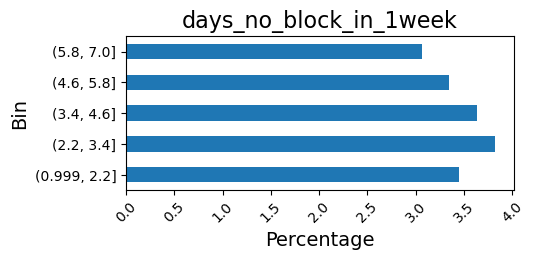

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 2.2]             1828              1.005174           3.446389
1    (2.2, 3.4]             1491              0.819866           3.822938
2    (3.4, 4.6]             2093              1.150892           3.631151
3    (4.6, 5.8]             2274              1.250419           3.342128
4    (5.8, 7.0]           174173             95.773649           3.064195 



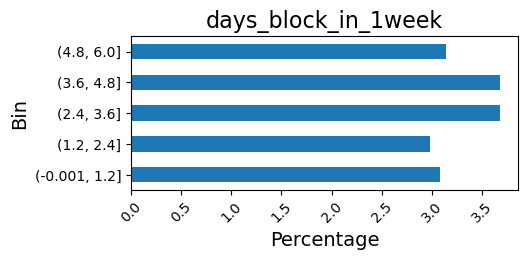

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 1.2]           175447             96.474192           3.075003
1     (1.2, 2.4]             1979              1.088206           2.981304
2     (2.4, 3.6]             1659              0.912245           3.676914
3     (3.6, 4.8]             1307              0.718689           3.672533
4     (4.8, 6.0]             1467              0.806669           3.135651 



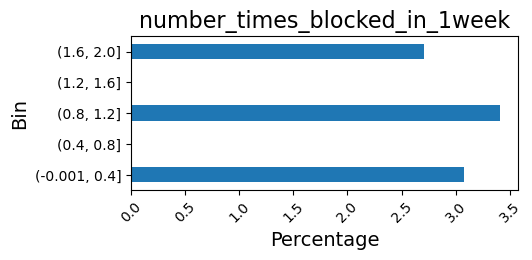

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 0.4]           177589             97.652027           3.076767
1     (0.4, 0.8]                0              0.000000                NaN
2     (0.8, 1.2]             4196              2.307282           3.408008
3     (1.2, 1.6]                0              0.000000                NaN
4     (1.6, 2.0]               74              0.040691           2.702703 



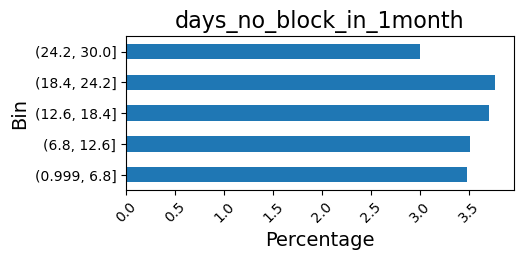

            bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 6.8]             3072              1.689221           3.483073
1   (6.8, 12.6]             4012              2.206105           3.514457
2  (12.6, 18.4]             5726              3.148593           3.702410
3  (18.4, 24.2]             9051              4.976933           3.767539
4  (24.2, 30.0]           159998             87.979149           3.005038 



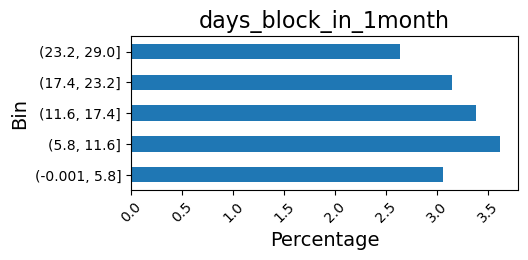

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 5.8]           166719             91.674869           3.056040
1    (5.8, 11.6]             7583              4.169714           3.613346
2   (11.6, 17.4]             4147              2.280338           3.375934
3   (17.4, 23.2]             2004              1.101953           3.143713
4   (23.2, 29.0]             1406              0.773126           2.631579 



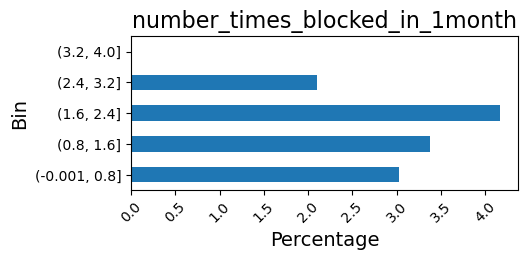

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 0.8]           155504             85.508003           3.027575
1     (0.8, 1.6]            24316             13.370798           3.372265
2     (1.6, 2.4]             1873              1.029919           4.164442
3     (2.4, 3.2]              143              0.078632           2.097902
4     (3.2, 4.0]               23              0.012647           0.000000 



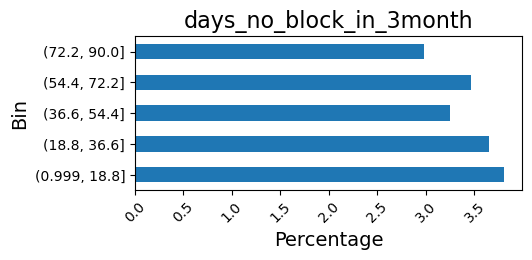

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (0.999, 18.8]             6362              3.498315           3.803835
1   (18.8, 36.6]             6142              3.377342           3.647021
2   (36.6, 54.4]             8565              4.709693           3.245768
3   (54.4, 72.2]            15447              8.493943           3.463456
4   (72.2, 90.0]           145343             79.920708           2.979160 



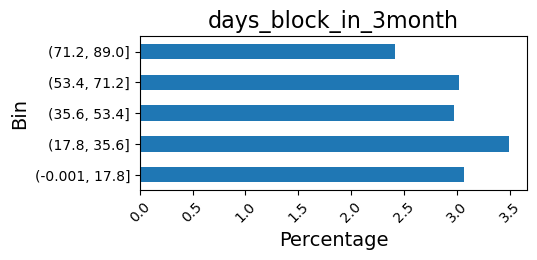

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 17.8]           164507             90.458542           3.066739
1    (17.8, 35.6]            10363              5.698371           3.493197
2    (35.6, 53.4]             3861              2.123073           2.978503
3    (53.4, 71.2]             1885              1.036517           3.023873
4    (71.2, 89.0]             1243              0.683497           2.413516 



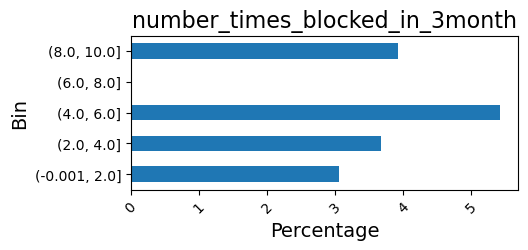

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 2.0]           174036             95.698316           3.052817
1     (2.0, 4.0]             7256              3.989904           3.679713
2     (4.0, 6.0]              498              0.273839           5.421687
3     (6.0, 8.0]               18              0.009898           0.000000
4    (8.0, 10.0]               51              0.028044           3.921569 



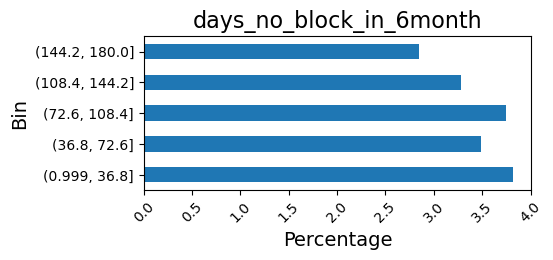

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0   (0.999, 36.8]            10296              5.661529           3.817016
1    (36.8, 72.6]            12573              6.913598           3.483655
2   (72.6, 108.4]            16204              8.910200           3.745989
3  (108.4, 144.2]            24206             13.310312           3.276047
4  (144.2, 180.0]           118580             65.204362           2.848710 



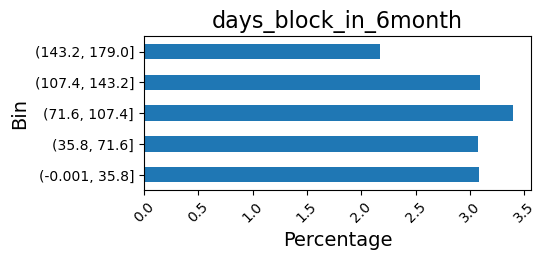

              bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 35.8]           163313             89.801989           3.083649
1    (35.8, 71.6]            11711              6.439604           3.074033
2   (71.6, 107.4]             3801              2.090081           3.393844
3  (107.4, 143.2]             1974              1.085456           3.090172
4  (143.2, 179.0]             1060              0.582869           2.169811 



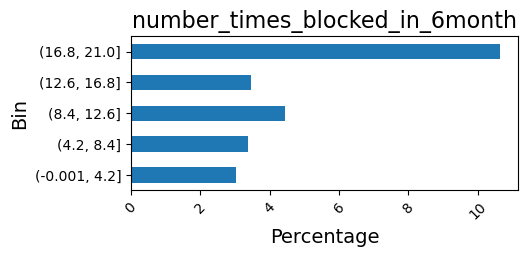

             bin  order_id Counts  order_id Percentages  NoShow Percentage
0  (-0.001, 4.2]           164638             90.530576           3.041218
1     (4.2, 8.4]            15314              8.420810           3.369466
2    (8.4, 12.6]             1686              0.927092           4.448399
3   (12.6, 16.8]              174              0.095679           3.448276
4   (16.8, 21.0]               47              0.025844          10.638298 



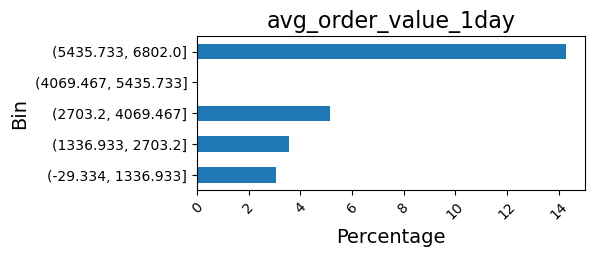

                    bin  order_id Counts  order_id Percentages  \
0   (-29.334, 1336.933]           177556             97.633881   
1    (1336.933, 2703.2]             3926              2.158815   
2    (2703.2, 4069.467]              350              0.192457   
3  (4069.467, 5435.733]               20              0.010998   
4    (5435.733, 6802.0]                7              0.003849   

   NoShow Percentage  
0           3.069454  
1           3.565970  
2           5.142857  
3           0.000000  
4          14.285714   



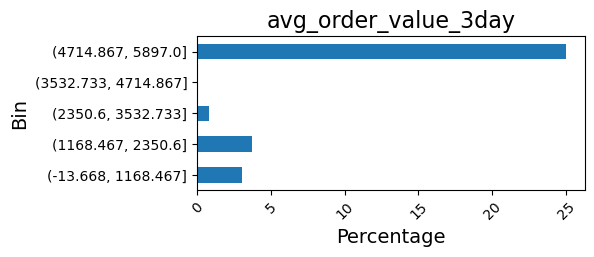

                    bin  order_id Counts  order_id Percentages  \
0   (-13.668, 1168.467]           178161             97.966557   
1    (1168.467, 2350.6]             3550              1.952062   
2    (2350.6, 3532.733]              128              0.070384   
3  (3532.733, 4714.867]               16              0.008798   
4    (4714.867, 5897.0]                4              0.002200   

   NoShow Percentage  
0           3.073624  
1           3.690141  
2           0.781250  
3           0.000000  
4          25.000000   



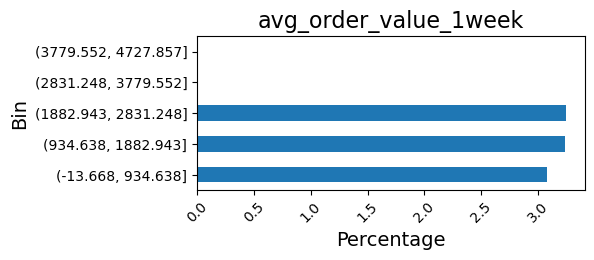

                    bin  order_id Counts  order_id Percentages  \
0    (-13.668, 934.638]           175369             96.431301   
1   (934.638, 1882.943]             6324              3.477419   
2  (1882.943, 2831.248]              154              0.084681   
3  (2831.248, 3779.552]               11              0.006049   
4  (3779.552, 4727.857]                1              0.000550   

   NoShow Percentage  
0           3.078651  
1           3.241619  
2           3.246753  
3           0.000000  
4           0.000000   



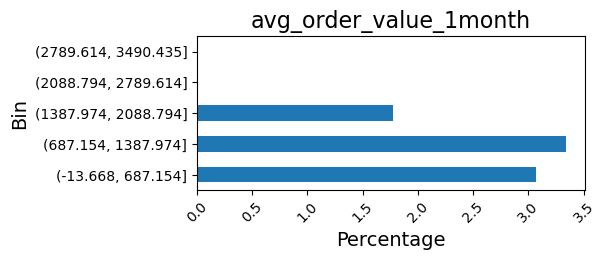

                    bin  order_id Counts  order_id Percentages  \
0    (-13.668, 687.154]           166986             91.821686   
1   (687.154, 1387.974]            14577              8.015551   
2  (1387.974, 2088.794]              282              0.155065   
3  (2088.794, 2789.614]               13              0.007148   
4  (2789.614, 3490.435]                1              0.000550   

   NoShow Percentage  
0           3.064329  
1           3.340879  
2           1.773050  
3           0.000000  
4           0.000000   



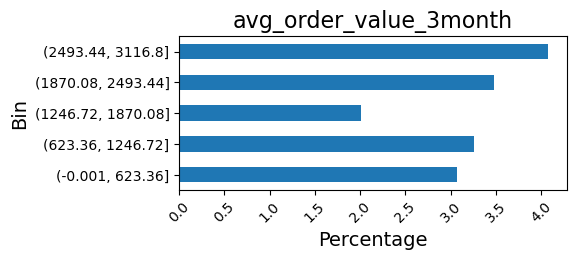

                  bin  order_id Counts  order_id Percentages  \
0    (-0.001, 623.36]           163452             89.878422   
1   (623.36, 1246.72]            17944              9.866985   
2  (1246.72, 1870.08]              299              0.164413   
3  (1870.08, 2493.44]              115              0.063236   
4   (2493.44, 3116.8]               49              0.026944   

   NoShow Percentage  
0           3.066344  
1           3.260143  
2           2.006689  
3           3.478261  
4           4.081633   



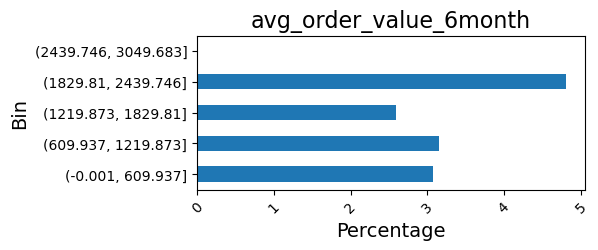

                    bin  order_id Counts  order_id Percentages  \
0     (-0.001, 609.937]           164625             90.523427   
1   (609.937, 1219.873]            16665              9.163693   
2   (1219.873, 1829.81]              463              0.254593   
3   (1829.81, 2439.746]              104              0.057187   
4  (2439.746, 3049.683]                2              0.001100   

   NoShow Percentage  
0           3.077297  
1           3.156316  
2           2.591793  
3           4.807692  
4           0.000000   



In [17]:
#Creating dataframes containing 5 bins for the understanding no show distribution using plots for numerical variables
def get_bins_and_no_show_percentage(df, column, target_column, num_bins=5):
    bins = np.linspace(df[column].min(), df[column].max(), num_bins+1)
    df['bin'] = pd.cut(df[column], bins=bins, include_lowest=True,duplicates="drop")
    bin_counts = df['bin'].value_counts()
    bin_percentages = (bin_counts / len(df)) * 100
    no_show_percentages = df.groupby('bin')[target_column].mean() * 100
    result_df = pd.DataFrame({
            'order_id Counts': bin_counts,
            'order_id Percentages': bin_percentages,
            'NoShow Percentage': no_show_percentages
        }).reset_index().rename(columns={'index':column+'_bin'})
        
    return result_df

cols=['ns_count_1day', 'ns_count_3day', 'ns_count_1week', 'ns_count_1month',
       'ns_count_6month', 'responded_lead_1day', 'responded_lead_3day',
       'responded_lead_1week', 'responded_lead_1month',
       'responded_lead_3month', 'responded_lead_6month', 'paf_count_1day',
       'paf_count_3day', 'paf_count_1week', 'paf_count_1month',
       'paf_count_6month', 'delivered_lead_1day', 'delivered_lead_3day',
       'delivered_lead_1week', 'delivered_lead_1month',
       'delivered_lead_3month', 'delivered_lead_6month',
       'service_delivery_rate_1day', 'service_delivery_rate_3day',
       'service_delivery_rate_1week', 'service_delivery_rate_1month',
       'service_delivery_rate_3month', 'service_delivery_rate_6month',
#        'Acceptance_Rate_1DAY', 'Acceptance_Rate_3DAY', 'Acceptance_Rate_1WEEK',
       'Acceptance_Rate_1MONTH', 'Acceptance_Rate_3MONTH',
       'Acceptance_Rate_6MONTH', 'pro_rating_1day', 'pro_rating_3day',
       'pro_rating_1week', 'pro_rating_1month', 'pro_rating_3month',
       'pro_rating_6month', 'total_income_1day', 'total_income_3day',
       'total_income_1week', 'total_income_1month', 'total_income_3month',
       'total_income_6month', 'days_no_block_in_1day', 'days_block_in_1day',
       'number_times_blocked_in_1day',
      'days_no_block_in_3day',
       'days_block_in_3day', 'number_times_blocked_in_3day',
       'days_no_block_in_1week', 'days_block_in_1week',
       'number_times_blocked_in_1week', 'days_no_block_in_1month',
       'days_block_in_1month', 'number_times_blocked_in_1month',
       'days_no_block_in_3month', 'days_block_in_3month',
       'number_times_blocked_in_3month', 'days_no_block_in_6month',
       'days_block_in_6month', 'number_times_blocked_in_6month',
       'avg_order_value_1day', 'avg_order_value_3day', 'avg_order_value_1week',
       'avg_order_value_1month', 'avg_order_value_3month',
       'avg_order_value_6month']

for x in cols:
    result = get_bins_and_no_show_percentage(df, x, 'ns')
    
    
    plot_horizontal_bar_chart(result,x)
    print(f"{result} \n")

- Plots with increasing trend or decreasing trend suggests that variable effects the target variable, plots with the U trend suggest that that variable has very less effect with the target
- Out of the 12 core categories which are ns_count, responded_lead, paf_count, delivered_lead, service_delivery_rate, pro_rating, total_income, days_no_block_in, days_block_in, number_times_blocked_in, avg_order_value, acceptance_rate Only 
 ns_count, service_delivery_rate, pro_rating, total_income had effect on no show


<a name='4.2'></a>

## Bivariate analysis categorical

In [18]:
#Creating dataframes with categories to understand distrutions of no shows for categorical variables

def analyze_categorical_column(df, column, target_column='NoShow'):
    
    result_df = df.groupby(column)[target_column].agg([
        ('Count', 'count'),
        ('Percentage', lambda x: (len(x) / len(df)) * 100),
        ('NoShow Percentage', lambda x: (x.sum() / len(x)) * 100)
    ]).reset_index()
    result_df = result_df.sort_values(by='NoShow Percentage', ascending=False)
    return result_df
    
    

for x in df.columns[2:4]:    
    results=analyze_categorical_column(df,x,"ns")
    print(f"{results} \n")


   is_exclusive_lead  Count  Percentage  NoShow Percentage
0                  0  91562   50.347797           4.082480
1                  1  90297   49.652203           2.072051 

  bookingslot  Count  Percentage  NoShow Percentage
2     Morning  26138   14.372673           4.246691
3       Night   1528    0.840211           3.337696
1     Evening  54373   29.898438           3.187244
0   AfterNoon  99820   54.888677           2.719896 



<a name='4.2.1'></a>

### SQL query for no show percentage for each bookslot category


In [19]:
query="""
SELECT 
    bookingslot,
    ROUND((SUM(ns) / COUNT(*) * 100),1) AS Percentage_Missed
FROM 
    df
GROUP BY 
    bookingslot;
    """

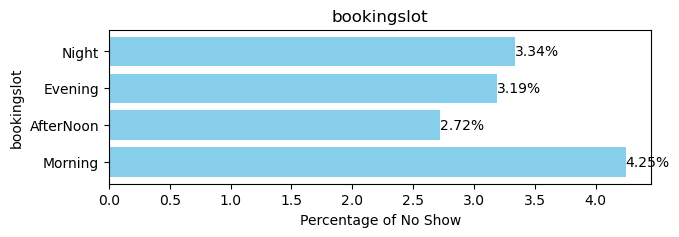

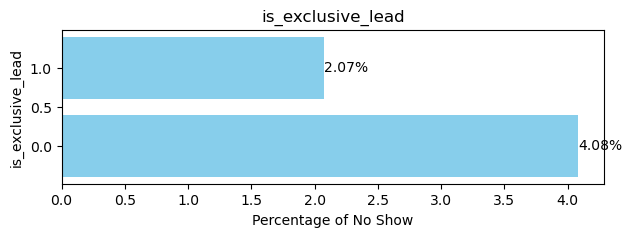

In [20]:
#Creating plots with categories to understand distrutions of no shows for categorical variables

def plot_no_show_percentage(categorical_column, target_column, data, category_order=None):
    
    # Group data by the categorical column and calculate the percentage of 'no show' class (1) for each category
    grouped = data.groupby(categorical_column)[target_column].mean() * 100
    
    # If category_order is provided, reorder the categories
    if category_order:
        grouped = grouped.reindex(category_order)
    
    # Create the plot
    plt.figure(figsize=(7, 2))
    bars = plt.barh(grouped.index, grouped.values, color='skyblue')
    plt.xlabel('Percentage of No Show')
    plt.ylabel(categorical_column)
    plt.title(f'{categorical_column}')
#     plt.gca().invert_yaxis()  # Invert y-axis to have the highest category at the top
    
    # Add labels to the bars
    for bar in bars:
        plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}%', 
                 va='center', ha='left')
    
    plt.show()

# Example usage:
# Assume 'data' is your DataFrame containing the data
# Assume 'categorical_column' is the categorical column
# Assume 'target_column' is the target column containing 'no show' (1) and 'show' (0) classes
# plot_no_show_percentage(categorical_column, target_column, data, category_order=None)
plot_no_show_percentage('bookingslot','ns',df,['Morning','AfterNoon','Evening','Night'])
plot_no_show_percentage('is_exclusive_lead','ns',df)


- The least no show rate for bookingslot is in the afternoon and the highest no show rate is in the morning
- exclusive_lead had lower no shows than not exclusive lead

<a name='4.3'></a>
## Correlation

In [21]:
#Checking correlation between different variables
def highlight_values(df):
   
    styled_df = df.style.format("{:.1f}")
    
    
    # Define a function to apply the highlight condition
    def highlight_condition(value):
        if value > 75 or value < -75:
            return 'background-color: lightsalmon'
        else:
            return ''
    
    # Apply the highlight condition to all columns
    highlighted_df = styled_df.applymap(highlight_condition)
    
    return highlighted_df


highlighted_df = highlight_values(df[cols].corr()*100)
print("\nHighlighted Correlation DataFrame:")
highlighted_df


Highlighted Correlation DataFrame:


,ns_count_1day,ns_count_3day,ns_count_1week,ns_count_1month,ns_count_6month,responded_lead_1day,responded_lead_3day,responded_lead_1week,responded_lead_1month,responded_lead_3month,responded_lead_6month,paf_count_1day,paf_count_3day,paf_count_1week,paf_count_1month,paf_count_6month,delivered_lead_1day,delivered_lead_3day,delivered_lead_1week,delivered_lead_1month,delivered_lead_3month,delivered_lead_6month,service_delivery_rate_1day,service_delivery_rate_3day,service_delivery_rate_1week,service_delivery_rate_1month,service_delivery_rate_3month,service_delivery_rate_6month,Acceptance_Rate_1MONTH,Acceptance_Rate_3MONTH,Acceptance_Rate_6MONTH,pro_rating_1day,pro_rating_3day,pro_rating_1week,pro_rating_1month,pro_rating_3month,pro_rating_6month,total_income_1day,total_income_3day,total_income_1week,total_income_1month,total_income_3month,total_income_6month,days_no_block_in_1day,days_block_in_1day,number_times_blocked_in_1day,days_no_block_in_3day,days_block_in_3day,number_times_blocked_in_3day,days_no_block_in_1week,days_block_in_1week,number_times_blocked_in_1week,days_no_block_in_1month,days_block_in_1month,number_times_blocked_in_1month,days_no_block_in_3month,days_block_in_3month,number_times_blocked_in_3month,days_no_block_in_6month,days_block_in_6month,number_times_blocked_in_6month,avg_order_value_1day,avg_order_value_3day,avg_order_value_1week,avg_order_value_1month,avg_order_value_3month,avg_order_value_6month
ns_count_1day,100.0,61.6,48.5,33.7,21.0,6.5,4.8,3.3,1.5,-3.0,-4.2,17.2,10.5,10.0,9.7,2.5,-1.0,0.5,-0.6,-2.5,-6.2,-6.8,-15.9,-11.5,-12.8,-14.2,-14.5,-14.2,6.7,6.6,7.5,-3.2,-2.5,-4.0,-6.0,-8.7,-8.8,-5.8,-5.4,-6.0,-6.1,-7.2,-8.1,-9.3,9.3,nan,-3.5,3.5,6.2,-3.0,2.4,3.7,-3.9,2.6,3.1,-7.0,2.5,3.7,-8.4,2.2,2.4,2.5,0.7,0.5,0.7,0.8,1.0
ns_count_3day,61.6,100.0,81.0,60.8,51.5,22.8,24.5,18.7,12.4,7.6,6.9,33.3,44.1,39.0,29.8,23.1,11.0,8.2,5.3,2.8,-1.6,-0.9,-11.8,-25.4,-25.4,-25.3,-25.8,-24.3,6.5,6.4,6.7,-3.7,-6.5,-7.5,-10.0,-13.9,-14.1,-5.9,-8.0,-8.2,-8.5,-9.7,-10.4,-4.6,4.6,nan,-2.0,2.3,6.2,-0.3,0.1,3.6,-2.5,1.2,2.6,-5.9,1.4,3.8,-7.1,1.2,1.8,0.6,-1.2,-1.5,-1.6,-1.8,-1.6
ns_count_1week,48.5,81.0,100.0,78.8,63.5,25.3,27.8,26.5,19.5,11.1,9.1,35.0,45.1,49.3,41.3,29.0,13.2,12.0,10.4,6.9,-0.3,-0.7,-10.9,-23.0,-33.2,-32.2,-32.5,-30.7,7.0,6.9,6.9,-6.1,-8.1,-11.1,-14.1,-19.0,-19.0,-6.0,-8.3,-9.3,-9.6,-11.4,-12.2,-5.4,5.4,nan,-2.4,3.0,8.3,1.1,-0.7,7.7,-1.7,-0.2,4.5,-5.7,0.7,5.3,-7.6,0.7,3.7,-0.7,-2.1,-2.4,-2.6,-2.5,-2.4
ns_count_1month,33.7,60.8,78.8,100.0,79.9,30.4,34.8,34.6,33.5,22.2,17.8,38.7,49.3,54.1,58.9,41.1,17.7,19.2,18.9,17.3,7.9,5.7,-9.4,-18.9,-27.3,-36.8,-37.2,-35.2,5.4,5.4,5.1,-7.9,-8.5,-12.6,-16.2,-20.5,-21.4,-6.2,-8.2,-9.4,-8.7,-10.1,-11.4,-2.5,2.5,nan,-0.8,1.6,3.1,1.7,-0.4,5.0,5.7,-3.7,5.3,0.7,-1.7,5.8,-3.6,-0.4,4.5,-2.0,-4.0,-4.9,-5.3,-5.6,-5.7
ns_count_6month,21.0,51.5,63.5,79.9,100.0,28.0,29.5,27.6,26.8,27.5,29.4,36.9,45.6,48.3,51.5,57.3,15.7,14.1,12.4,11.9,10.3,14.0,-8.6,-18.3,-26.0,-35.8,-44.5,-43.4,6.8,7.1,6.6,-5.7,-8.7,-11.1,-14.5,-19.0,-21.7,-5.8,-7.8,-9.2,-8.6,-6.6,-4.8,-2.6,2.6,nan,-1.4,2.4,2.4,0.9,1.1,3.8,6.0,0.5,5.4,12.1,-1.8,9.2,12.9,-1.3,11.5,-3.0,-4.8,-5.4,-6.6,-6.9,-7.5
responded_lead_1day,6.5,22.8,25.3,30.4,28.0,100.0,81.1,74.5,61.8,49.0,41.9,65.5,59.0,56.9,49.4,38.8,91.5,76.2,70.8,59.4,46.0,38.9,24.7,9.8,6.0,5.1,3.2,2.9,-16.9,-16.7,-15.9,-5.8,-7.5,-9.0,-11.9,-13.6,-13.9,11.2,7.3,4.6,2.6,-0.1,0.1,-8.0,8.0,nan,-1.0,1.6,6.3,-0.0,0.1,3.1,-3.2,1.0,1.4,-4.8,1.7,0.1,-3.0,-0.3,-3.2,-17.8,-21.5,-24.3,-26.9,-27.3,-27.4
responded_lead_3day,4.8,24.5,27.8,34.8,29.5,81.1,100.0,90.2,74.1,58.6,48.3,54.5,75.0,71.8,61.8,45.5,73.5,92.8,84.1,70.1,54.3,44.6,19.4,11.1,5.9,3.7,1.3,0.8,-20.7,-20.2,-19.3,-10.6,-9.3,-10.9,-12.2,-14.3,-14.8,5.3,18.0,13.9,9.6,5.1,3.9,-7.6,7.6,nan,6.4,-5.4,6.7,6.0,-5.9,0.3,-1.4,-0.7,0.8,-4.0,0.3,-0.5,-4.3,-0.5,-3.9,-17.4,-22.6,-25.9,-29.0,-29.7,-29.8
responded_lead_1week,3.3,18.7,26.5,34.6,27.6,74.5,90.2,100.0,83.6,65.9,54.1,47.5,65.2,77.0,68.3,48.9,68.9,85.0,94.6,79.7,62.1,50.8,19.4,12.1,7.9,5.3,3.

- The dataframe above shows the correlation between all the variables in the data, the ones highlighted in orange represent that these variables have correlation higher than 75% or lesser than -75%
- We do not see much correlation between each category and see correlation within the categories
- There are high number of correlated features, We see of out the 12 core categories which are ns_count, responded_lead, paf_count, delivered_lead, service_delivery_rate, pro_rating, total_income, days_no_block_in, days_block_in, number_times_blocked_in, avg_order_value, acceptance_rate each category has a 3day and 3month feature which is correlated with most of the other features. By selecting only these variables we could get most information from the categories
- In case we dont have 3 month feature for the category, we select 6 month features
#incase you dont see the highlighted notebook, please run the code ( should be visible then)

In [22]:
#Combing all the 3 days and 3 months data columns
three_months=[i for i in df.columns if '3month' in i]
three_days=[i for i in df.columns if '3day' in i]
three_cols=three_months+three_days
three_cols.append('Acceptance_Rate_3MONTH')
three_cols.append('Acceptance_Rate_3DAY')
print("three_cols")
print(three_cols)
print(len(three_cols),"\n")
print("three_months")
print(three_months)
print(len(three_months),"\n")
print("three_days")
print(three_days)
print(len(three_days),"\n")

three_cols
['responded_lead_3month', 'delivered_lead_3month', 'service_delivery_rate_3month', 'pro_rating_3month', 'total_income_3month', 'days_no_block_in_3month', 'days_block_in_3month', 'number_times_blocked_in_3month', 'avg_order_value_3month', 'ns_count_3day', 'responded_lead_3day', 'paf_count_3day', 'delivered_lead_3day', 'service_delivery_rate_3day', 'pro_rating_3day', 'total_income_3day', 'days_no_block_in_3day', 'days_block_in_3day', 'number_times_blocked_in_3day', 'avg_order_value_3day', 'Acceptance_Rate_3MONTH', 'Acceptance_Rate_3DAY']
22 

three_months
['responded_lead_3month', 'delivered_lead_3month', 'service_delivery_rate_3month', 'pro_rating_3month', 'total_income_3month', 'days_no_block_in_3month', 'days_block_in_3month', 'number_times_blocked_in_3month', 'avg_order_value_3month']
9 

three_days
['ns_count_3day', 'responded_lead_3day', 'paf_count_3day', 'delivered_lead_3day', 'service_delivery_rate_3day', 'pro_rating_3day', 'total_income_3day', 'days_no_block_in_3day',

In [23]:
#adding 6 months columns where 3 months column are not present , along with other remaining valuable columns
final_cols=three_cols+['paf_count_6month','ns_count_6month','bookingslot','is_exclusive_lead','ns']
print("final_cols")
print(final_cols)
print(len(final_cols))

final_cols
['responded_lead_3month', 'delivered_lead_3month', 'service_delivery_rate_3month', 'pro_rating_3month', 'total_income_3month', 'days_no_block_in_3month', 'days_block_in_3month', 'number_times_blocked_in_3month', 'avg_order_value_3month', 'ns_count_3day', 'responded_lead_3day', 'paf_count_3day', 'delivered_lead_3day', 'service_delivery_rate_3day', 'pro_rating_3day', 'total_income_3day', 'days_no_block_in_3day', 'days_block_in_3day', 'number_times_blocked_in_3day', 'avg_order_value_3day', 'Acceptance_Rate_3MONTH', 'Acceptance_Rate_3DAY', 'paf_count_6month', 'ns_count_6month', 'bookingslot', 'is_exclusive_lead', 'ns']
27


After selecting 3 day, 3 month, 6 month features from each category, is_exclusive_lead and bookingslot we finally have 27 variables including the target variable

<a name='5'></a>
# Feature engineering

In [24]:
#Checking the counts of no show where 'Acceptance_Rate_3DAY' is inf
df[df['Acceptance_Rate_3DAY']==np.inf]['ns'].value_counts()

ns
0    42
1     2
Name: count, dtype: int64

Since there are less number of inf values we can impute them with the median 

<a name='5.1'></a>

## Treating infinity values with median

In [25]:
#Checking the median of 'Acceptance_Rate_3DAY' and inf values in each column
print(f"Acceptance_Rate_3DAY median : {df['Acceptance_Rate_3DAY'].median()}")
final_df=df[final_cols]
inf=count_inf(final_df)
inf

Acceptance_Rate_3DAY median : 1.2727272727272727


responded_lead_3month              0
delivered_lead_3month              0
service_delivery_rate_3month       0
pro_rating_3month                  0
total_income_3month                0
days_no_block_in_3month            0
days_block_in_3month               0
number_times_blocked_in_3month     0
avg_order_value_3month             0
ns_count_3day                      0
responded_lead_3day                0
paf_count_3day                     0
delivered_lead_3day                0
service_delivery_rate_3day         0
pro_rating_3day                    0
total_income_3day                  0
days_no_block_in_3day              0
days_block_in_3day                 0
number_times_blocked_in_3day       0
avg_order_value_3day               0
Acceptance_Rate_3MONTH             0
Acceptance_Rate_3DAY              44
paf_count_6month                   0
ns_count_6month                    0
bookingslot                        0
is_exclusive_lead                  0
ns                                 0
d

In [26]:
#Imputing inf values with median
def replace_inf(df,col):
    df[col].replace(-np.inf,df[col].median(),inplace=True)
    df[col].replace(np.inf,df[col].median(),inplace=True)
    return df

final_inf_df=replace_inf(final_df,'Acceptance_Rate_3DAY')
inf=count_inf(final_inf_df)
inf

responded_lead_3month             0
delivered_lead_3month             0
service_delivery_rate_3month      0
pro_rating_3month                 0
total_income_3month               0
days_no_block_in_3month           0
days_block_in_3month              0
number_times_blocked_in_3month    0
avg_order_value_3month            0
ns_count_3day                     0
responded_lead_3day               0
paf_count_3day                    0
delivered_lead_3day               0
service_delivery_rate_3day        0
pro_rating_3day                   0
total_income_3day                 0
days_no_block_in_3day             0
days_block_in_3day                0
number_times_blocked_in_3day      0
avg_order_value_3day              0
Acceptance_Rate_3MONTH            0
Acceptance_Rate_3DAY              0
paf_count_6month                  0
ns_count_6month                   0
bookingslot                       0
is_exclusive_lead                 0
ns                                0
dtype: int64

All the infinity values have been imputed

<a name='5.2'></a>

## Encoding booking slot

Since Bookingslot have an order, we can do an ordinal encoding to the feature

In [27]:
#Encoding bookinglslot as Morning-0, AfterNoon-1, Evening-2, Night-3 as ordinal encoding
ordinal_encoder = OrdinalEncoder(categories=[['Morning', 'AfterNoon', 'Evening', 'Night']])
final_inf_df['bookingslot'] = ordinal_encoder.fit_transform(final_inf_df[['bookingslot']])
final_inf_df['bookingslot'].value_counts(normalize=True)

bookingslot
1.0    0.548887
2.0    0.298984
0.0    0.143727
3.0    0.008402
Name: proportion, dtype: float64

In [28]:
#Checking final data frame
final_inf_df

,responded_lead_3month,delivered_lead_3month,service_delivery_rate_3month,pro_rating_3month,total_income_3month,days_no_block_in_3month,days_block_in_3month,number_times_blocked_in_3month,avg_order_value_3month,ns_count_3day,responded_lead_3day,paf_count_3day,delivered_lead_3day,service_delivery_rate_3day,pro_rating_3day,total_income_3day,days_no_block_in_3day,days_block_in_3day,number_times_blocked_in_3day,avg_order_value_3day,Acceptance_Rate_3MONTH,Acceptance_Rate_3DAY,paf_count_6month,ns_count_6month,bookingslot,is_exclusive_lead,ns
0,97,75,0.773196,4.793478,38404.455871,90,0,0,399.288660,0,6,1,5,0.833333,5.000000,1877.392747,3,0,0,157.833333,1.886076,1.500000,44,5,1.0,0,0
1,161,130,0.807453,4.741667,52708.768094,90,0,0,384.906832,0,7,2,5,0.714286,4.750000,2028.609741,3,0,0,302.857143,1.676692,1.500000,76,4,1.0,0,0
2,97,79,0.814433,4.882353,24786.740728,90,0,0,273.268041,0,5,3,2,0.400000,4.500000,776.514019,3,0,0,149.400000,1.087500,1.000000,36,1,1.0,0,0
3,215,128,0.595349,4.995798,53846.316431,89,0,0,422.446512,0,7,4,3,0.428571,5.000000,1421.109832,3,0,0,406.285714,1.500000,1.200000,184,19,1.0,0,0
4,290,219,0.755172,4.632812,54323.306404,90,0,0,162.231034,0,7,2,5,0.714286,4.000000,1015.611112,3,0,0,162.428571,1.221198,1.200000,138,1,1.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181854,190,117,0.615789,4.814516,92344.608055,76,14,4,306.210526,0,6,5,1,0.166667,5.000000,721.599925,3,0,0,0.000000,2.924370,1.500000,130,5,1.0,1,0
181855,165,136,0.824242,4.855670,102801.452700,90,0,0,689.587879,0,7,2,5,0.714286,5.000000,2103.469289,3,0,0,337.857143,1.605839,2.000000,53,4,0.0,0,0
181856,331,276,0.833837,4.937500,56065.376354,81,9,2,123.558912,0,14,1,13,0.928571,4.944444,2760.203274,3,0,0,222.000000,1.096154,1.153846,108,4,0.0,1,0
181857,576,417,0.723958,4.958661,100415.025356,90,0,0,286.413194,0,19,4,15,0.789474,5.000000,2006.989137,3,0,0,127.157895,1.122549,1.142857,220,4,1.0,0,0


<a name='5.3'></a>

## Train test split

In [29]:
#Splitting the data into train set and test set
y=final_inf_df['ns']
X=final_inf_df.drop('ns',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X,y ,random_state=104,test_size=0.3,shuffle=True) 

In [30]:
#Checking the stats of train set and test set
print(f"The shape for Train : {y_train.shape}")
print(f"The count of Train split is: {y_train.value_counts()}")
print(f"The % of Train split is:{y_train.value_counts(normalize=True)*100} \n")

print(f"The shape for Test : {y_test.shape}")
print(f"The count of Test split is: {y_test.value_counts()}")
print(f"The % of Test split is:{y_test.value_counts(normalize=True)*100} \n")

The shape for Train : (127301,)
The count of Train split is: ns
0    123397
1      3904
Name: count, dtype: int64
The % of Train split is:ns
0    96.933253
1     3.066747
Name: proportion, dtype: float64 

The shape for Test : (54558,)
The count of Test split is: ns
0    52853
1     1705
Name: count, dtype: int64
The % of Test split is:ns
0    96.874885
1     3.125115
Name: proportion, dtype: float64 



We have only 3% minority class in both the training and testing set

<a name='5.4'></a>
## Imbalanced treatment

In [31]:
#Checking the counts of each class of target
y_train.value_counts()

ns
0    123397
1      3904
Name: count, dtype: int64

<a name='5.4.1'></a>
### Oversampling

Upsampling involves randomly duplicating observations from the minority class to balance the dataset.

In [32]:
#Increasing the rows of minority class
os =  RandomOverSampler(sampling_strategy=0.11)
X_train_upsample, y_train_upsample = os.fit_resample(X_train, y_train)
print(f'Original dataset shape {y_train.value_counts(normalize=True)}, {y_train.value_counts()} \n')
print(f'Resampled dataset shape {y_train_upsample.value_counts(normalize=True)}, {y_train_upsample.value_counts()}' )

Original dataset shape ns
0    0.969333
1    0.030667
Name: proportion, dtype: float64, ns
0    123397
1      3904
Name: count, dtype: int64 

Resampled dataset shape ns
0    0.900905
1    0.099095
Name: proportion, dtype: float64, ns
0    123397
1     13573
Name: count, dtype: int64


Increased the minority class from 3% to 10%

<a name='5.4.2'></a>
### Undersampling

Downsampling involves randomly removing observations from the majority class to balance the dataset.

In [33]:
#Decreasing the rows of majority class
rus = RandomUnderSampler(sampling_strategy=.11, random_state=42)
X_train_downsample, y_train_downsample = rus.fit_resample(X_train, y_train)
print(f'Original dataset shape {y_train.value_counts(normalize=True)}, {y_train.value_counts()} \n')
print(f'Resampled dataset shape {y_train_downsample.value_counts(normalize=True)}, {y_train_downsample.value_counts()}')

Original dataset shape ns
0    0.969333
1    0.030667
Name: proportion, dtype: float64, ns
0    123397
1      3904
Name: count, dtype: int64 

Resampled dataset shape ns
0    0.900899
1    0.099101
Name: proportion, dtype: float64, ns
0    35490
1     3904
Name: count, dtype: int64


Decreased the majority class from 97% to 90%

<a name='5.4.3'></a>
### SMOTE

SMOTE creates synthetic samples from the minority class by interpolating between existing observations, enhancing diversity and aiding in balancing the dataset.

In [34]:
#Increasing the rows of minority class using synthetic data
smote = SMOTE(sampling_strategy=0.11)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
print(f'Original dataset shape {y_train.value_counts(normalize=True)}, {y_train.value_counts()} \n')
print(f'Resampled dataset shape {y_train_smote.value_counts(normalize=True)}, {y_train_smote.value_counts()}')

Original dataset shape ns
0    0.969333
1    0.030667
Name: proportion, dtype: float64, ns
0    123397
1      3904
Name: count, dtype: int64 

Resampled dataset shape ns
0    0.900905
1    0.099095
Name: proportion, dtype: float64, ns
0    123397
1     13573
Name: count, dtype: int64


Increased the minority class from 3% to 10%

<a name='6'></a>
# Feature selection

In this section, we will perform feature selection to identify the most important features for our model. Feature selection is crucial for making the model simpler, faster, and more interpretable.

To further refine our feature selection, we will use machine learning models to compute the feature importance. We will use Decision Trees for this purpose. This step will help us understand which features are most influential in predicting the target variable, ns.

We will use a Decision Tree model to get the feature importance scores. We will focus on features that have at least 1% importance in either of the models.

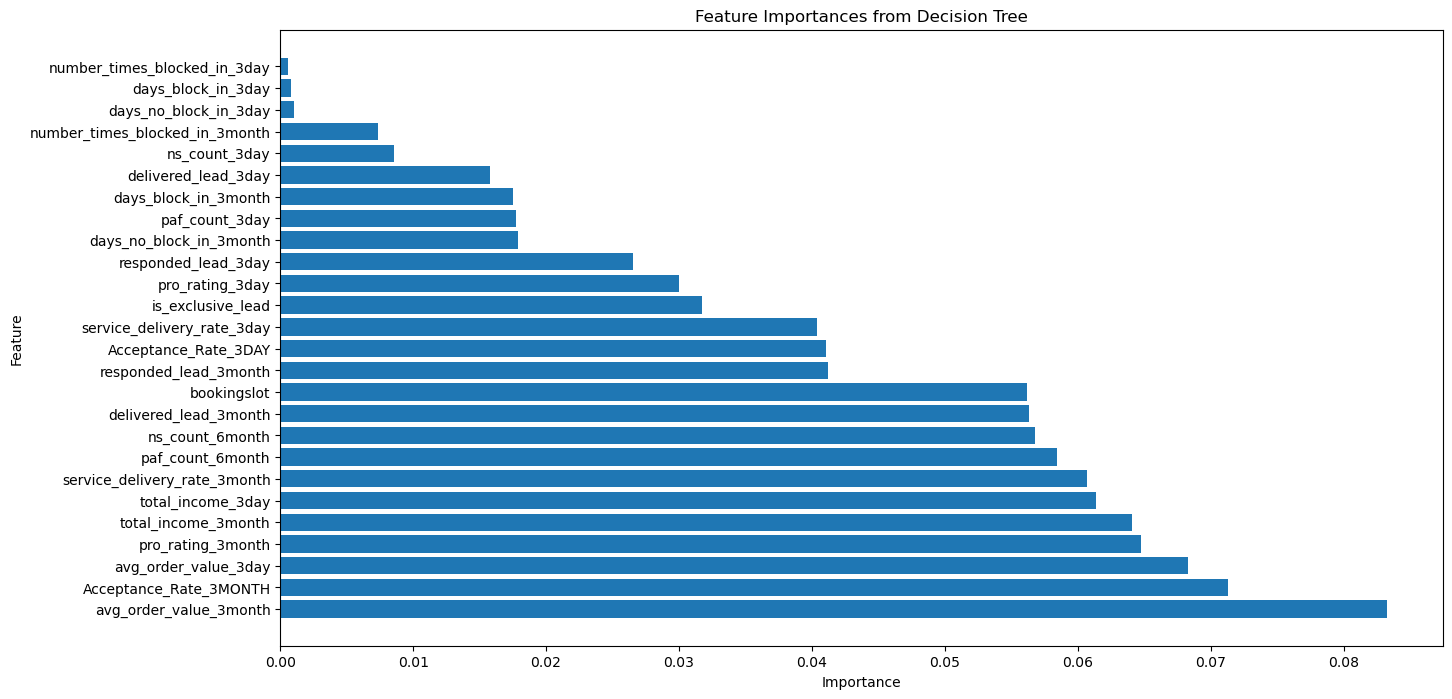

Important features based on Decision Tree:
                         Feature  Importance
8         avg_order_value_3month    0.083294
20        Acceptance_Rate_3MONTH    0.071304
19          avg_order_value_3day    0.068322
3              pro_rating_3month    0.064783
4            total_income_3month    0.064074
15             total_income_3day    0.061362
2   service_delivery_rate_3month    0.060680
22              paf_count_6month    0.058462
23               ns_count_6month    0.056774
1          delivered_lead_3month    0.056349
24                   bookingslot    0.056192
0          responded_lead_3month    0.041182
21          Acceptance_Rate_3DAY    0.041067
13    service_delivery_rate_3day    0.040407
25             is_exclusive_lead    0.031760
14               pro_rating_3day    0.030020
10           responded_lead_3day    0.026568
5        days_no_block_in_3month    0.017897
11                paf_count_3day    0.017762
6           days_block_in_3month    0.017505
12          

In [35]:
# Initialize the Decision Tree model
decision_tree_model = DecisionTreeClassifier(class_weight='balanced', random_state=42)

# Fit the model on the training data
decision_tree_model.fit(X_train, y_train)

# Get the feature importances
feature_importances = decision_tree_model.feature_importances_

# Create a DataFrame for the feature importances
feature_importances_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})

# Sort the DataFrame by the importances
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Filter features with at least 1% importance
important_features_tree = feature_importances_df[feature_importances_df['Importance'] >= 0.01]

# Plotting all feature importances
plt.figure(figsize=(15, 8))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Decision Tree')
plt.show()

print("Important features based on Decision Tree:")
print(important_features_tree)
print(f"Number of important features in Decision Tree: {len(important_features_tree)}")

In [36]:
# Convert the important features to lists
important_features_tree_list = important_features_tree['Feature'].values.tolist()

print("important features:")
display(important_features_tree_list)
print(f"Total number important features: {len(important_features_tree_list)}")

important features:


['avg_order_value_3month',
 'Acceptance_Rate_3MONTH',
 'avg_order_value_3day',
 'pro_rating_3month',
 'total_income_3month',
 'total_income_3day',
 'service_delivery_rate_3month',
 'paf_count_6month',
 'ns_count_6month',
 'delivered_lead_3month',
 'bookingslot',
 'responded_lead_3month',
 'Acceptance_Rate_3DAY',
 'service_delivery_rate_3day',
 'is_exclusive_lead',
 'pro_rating_3day',
 'responded_lead_3day',
 'days_no_block_in_3month',
 'paf_count_3day',
 'days_block_in_3month',
 'delivered_lead_3day']

Total number important features: 21


<a name='6.1'></a>
## Final data

We will filter all our available datasets with the important_features_tree_list.

In [37]:
# Filter the original training and test sets
X_train = X_train[important_features_tree_list]
X_test = X_test[important_features_tree_list]


# Filter the upsampled, downsampled, and SMOTE sets
X_train_upsample = X_train_upsample[important_features_tree_list]
X_train_downsample = X_train_downsample[important_features_tree_list]
X_train_smote = X_train_smote[important_features_tree_list]



<a name='7'></a>

# Model build


<a name='7.1'></a>

## Compare base models

We will train multiple machine learning models (Logistic Regression, Decision Tree, Random Forest, and XGBoost) with Stratified K-Fold cross-validation on the original dataset to identify the one that performs best based on the ROC AUC.

In [38]:
# Initialize Stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize models
logistic_model = LogisticRegression(random_state=42)
decision_tree_model = DecisionTreeClassifier(random_state=42)
random_forest_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Perform cross-validation for each model
models = {'Logistic Regression': logistic_model, 
          'Decision Tree': decision_tree_model, 
          'Random Forest': random_forest_model, 
          'XGBoost': xgb_model}

for name, model in models.items():
    model.fit(X_train,y_train)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    
    print(f"Results for {name}:")
    print(f"Train ROC AUC: {score}")
    print(f"Test ROC AUC: {roc_auc}")
    print("------")

Results for Logistic Regression:
Train ROC AUC: 0.5579227562268214
Test ROC AUC: 0.5574120729808172
------
Results for Decision Tree:
Train ROC AUC: 0.5265689814398389
Test ROC AUC: 0.5245404159481122
------
Results for Random Forest:
Train ROC AUC: 0.5754630881881935
Test ROC AUC: 0.5632895099466105
------
Results for XGBoost:
Train ROC AUC: 0.634108268551495
Test ROC AUC: 0.634304225524976
------


XGBoost is the best performing model with highest ROC AUC trained on the original dataset.

<a name='7.2'></a>

## Compare  datasets

We will fit the best model (XGBoost) on original data set as well as different resampled data sets, and evaluate on the test set. This is to see how the model performs on different versions of the dataset. It will help us identify which resampling technique (if any) improves the model's performance on the test set.

In [38]:
# Initialize the XGBoost model for resampled datasets
xgb_model= XGBClassifier(random_state=42)

# Datasets
datasets = {
    'Original': (X_train, y_train),
    'Upsampled': (X_train_upsample, y_train_upsample),
    'Downsampled': (X_train_downsample, y_train_downsample),
    'SMOTE': (X_train_smote, y_train_smote)
}

# To store results
results = {}

# Loop through each dataset
for name, (X, y) in datasets.items():
   
    # Fit the model
    xgb_model.fit(X, y)
    
    
    #Make predictions on the train set 
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(xgb_model, X, y, cv=skf, scoring='roc_auc', n_jobs=-1).mean()

    
    # Make predictions on the test set
    y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Get the probabilities for the positive class
    
    # Evaluate the model
    roc_auc = roc_auc_score(y_test, y_pred_prob)  # Use probabilities for ROC AUC
    results[name] = {'Train ROC AUC': score,'Test ROC AUC': roc_auc}

# Display the results
for name, metrics in results.items():
    print(f"Results for {name}:")
    print(f"Train ROC AUC : {metrics['Train ROC AUC']}")
    print(f"Test ROC AUC : {metrics['Test ROC AUC']}")
    print("------")

Results for Original:
Train ROC AUC : 0.634108268551495
Test ROC AUC : 0.634304225524976
------
Results for Upsampled:
Train ROC AUC : 0.8807343402104097
Test ROC AUC : 0.6262077527817014
------
Results for Downsampled:
Train ROC AUC : 0.6319236364333872
Test ROC AUC : 0.6281353533368405
------
Results for SMOTE:
Train ROC AUC : 0.9009158085365225
Test ROC AUC : 0.6336194623354445
------


- Upsampled and SMOTE results show that they are overfitting 
- Based on the results, the XGBoost model trained on the original dataset and evaluated on test set performs slightly better in terms of ROC AUC compared to the models trained on the resampled datasets.


<a name='7.3'></a>

## Final model hypertuning

We will fine-tune the hyperparameters of the selected model using Hyperopt. The objective is to maximize the ROC AUC score. Hyperopt employs Bayesian optimization to find the best hyperparameters more efficiently than grid search or random search.

Here's a general outline of the steps we will follow:

- Define the Objective Function: This function will take in hyperparameters, train the Gradient Boosting model, and return the metric we want to optimize (in this case, ROC AUC).
- Define the Hyperparameter Space: Specify the range of values for each hyperparameter we want to tune.
    - n_estimators: The number of boosting rounds or trees to build. It's important to tune it properly as a very large number would make the model overfit. Range: [50, 1000].
    - max_depth: The maximum depth of the individual estimators. The depth of the tree can be used to control over-fitting. Range: [3, 14].
    - learning_rate: Step size shrinkage used to prevent overfitting. Range is [0.01, 0.2].
    - gamma: Minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be. Range: [0, 0.5].
    - colsample_bytree: The fraction of features to choose for each boosting round. Used for subsampling of columns. Range: [0.3, 1].
    - subsample: The fraction of samples to be used for each boosting round. Range: [0.6, 1].
    - min_child_weight: Minimum sum of instance weight (hessian) needed in a child. Used to control over-fitting. Range: [1, 10].
- Run Optimization: Use Hyperopt to run the optimization process.

In [39]:
best_score = 0  # Initialize the best score
iteration = 0  # Initialize the iteration counter

# Define the objective function
def objective(params):
    global best_score  # Declare best_score as global to update it
    global iteration  # Declare iteration as global to update it
    iteration += 1  # Increment the iteration counter
    
    clf = XGBClassifier(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        gamma=params['gamma'],
        colsample_bytree=params['colsample_bytree'],
        subsample=params['subsample'],
        min_child_weight=int(params['min_child_weight']),
        random_state=42
    )
    
    # Stratified K-Fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(clf, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
    
    if score > best_score:
        best_score = score
        print(f"New best score at iteration {iteration}: {best_score}")
        display("Best parameters so far:", params)
    
    return {'loss': -score, 'status': STATUS_OK}

# Define the parameter space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 1000, 1),
    'max_depth': hp.quniform('max_depth', 3, 14, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.2),
    'gamma': hp.uniform('gamma', 0, 0.5),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
    'subsample': hp.uniform('subsample', 0.6, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1)
}

# Initialize a trials object
trials = Trials()

# Run the hyperparameter optimization
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

New best score at iteration 1: 0.6265637698161794                                                                      
  0%|                                                                          | 0/100 [00:12<?, ?trial/s, best loss=?]

'Best parameters so far:'

{'colsample_bytree': 0.8440031423460577,
 'gamma': 0.4503611298871086,
 'learning_rate': 0.13512655023511944,
 'max_depth': 6.0,
 'min_child_weight': 8.0,
 'n_estimators': 548.0,
 'subsample': 0.9197076686796148}

New best score at iteration 4: 0.6443943654763403                                                                      
  3%|█▍                                             | 3/100 [01:08<35:52, 22.19s/trial, best loss: -0.6265637698161794]

'Best parameters so far:'

{'colsample_bytree': 0.6556898100449564,
 'gamma': 0.37735052022292065,
 'learning_rate': 0.05582318775034913,
 'max_depth': 9.0,
 'min_child_weight': 8.0,
 'n_estimators': 355.0,
 'subsample': 0.9376925376367495}

New best score at iteration 6: 0.6580104038953462                                                                      
  5%|██▎                                            | 5/100 [01:28<25:37, 16.18s/trial, best loss: -0.6443943654763403]

'Best parameters so far:'

{'colsample_bytree': 0.9134648594405275,
 'gamma': 0.46655717447953504,
 'learning_rate': 0.07250664460597349,
 'max_depth': 6.0,
 'min_child_weight': 3.0,
 'n_estimators': 229.0,
 'subsample': 0.7453896277329454}

New best score at iteration 15: 0.6656443775672403                                                                     
 14%|██████▍                                       | 14/100 [03:35<24:32, 17.12s/trial, best loss: -0.6580104038953462]

'Best parameters so far:'

{'colsample_bytree': 0.7659656048420493,
 'gamma': 0.47253040902044463,
 'learning_rate': 0.0611293436441472,
 'max_depth': 4.0,
 'min_child_weight': 5.0,
 'n_estimators': 421.0,
 'subsample': 0.7634053259112106}

New best score at iteration 21: 0.671520492887815                                                                      
 20%|█████████▏                                    | 20/100 [05:07<25:37, 19.22s/trial, best loss: -0.6656443775672403]

'Best parameters so far:'

{'colsample_bytree': 0.7411299925927386,
 'gamma': 0.003989770666978976,
 'learning_rate': 0.013555867290057491,
 'max_depth': 3.0,
 'min_child_weight': 4.0,
 'n_estimators': 300.0,
 'subsample': 0.8262612531537452}

New best score at iteration 22: 0.672421327952603                                                                      
 21%|█████████▊                                     | 21/100 [05:17<20:22, 15.47s/trial, best loss: -0.671520492887815]

'Best parameters so far:'

{'colsample_bytree': 0.7554132265181625,
 'gamma': 0.005126780874988024,
 'learning_rate': 0.010129295535332782,
 'max_depth': 3.0,
 'min_child_weight': 4.0,
 'n_estimators': 456.0,
 'subsample': 0.8427808753416633}

New best score at iteration 25: 0.6731205954578016                                                                     
 24%|███████████▎                                   | 24/100 [05:36<11:02,  8.71s/trial, best loss: -0.672421327952603]

'Best parameters so far:'

{'colsample_bytree': 0.9951004917271847,
 'gamma': 0.05372454534545688,
 'learning_rate': 0.024164892492384342,
 'max_depth': 4.0,
 'min_child_weight': 2.0,
 'n_estimators': 480.0,
 'subsample': 0.825972917691676}

New best score at iteration 39: 0.6743624539654113                                                                     
 38%|█████████████████▍                            | 38/100 [08:17<11:24, 11.05s/trial, best loss: -0.6731205954578016]

'Best parameters so far:'

{'colsample_bytree': 0.8115119525750456,
 'gamma': 0.02008346496999342,
 'learning_rate': 0.02461026519422073,
 'max_depth': 4.0,
 'min_child_weight': 4.0,
 'n_estimators': 251.0,
 'subsample': 0.9362327567584502}

New best score at iteration 66: 0.6748304291063352                                                                     
 65%|█████████████████████████████▉                | 65/100 [13:28<07:21, 12.63s/trial, best loss: -0.6743624539654113]

'Best parameters so far:'

{'colsample_bytree': 0.744874574085743,
 'gamma': 0.020789545069511663,
 'learning_rate': 0.012766070009389481,
 'max_depth': 5.0,
 'min_child_weight': 4.0,
 'n_estimators': 466.0,
 'subsample': 0.8423959980452925}

100%|█████████████████████████████████████████████| 100/100 [20:22<00:00, 12.23s/trial, best loss: -0.6748304291063352]


In [39]:
#tried multiple iteration with the above method and the best parameter is below
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_params ={
    'colsample_bytree': 0.799148732713947,
 'gamma': 0.38107219201370385,
 'learning_rate': 0.010254820498753913,
 'max_depth': 4,
 'min_child_weight': 10,
 'n_estimators': 548,
 'subsample': 0.7240564379251414
}
xgb_model_final = XGBClassifier(**best_params)
xgb_model_final.fit(X_train, y_train)
y_pred_prob = xgb_model_final.predict_proba(X_test)[:, 1]
score = cross_val_score(xgb_model_final, X_train, y_train, cv=skf, scoring='roc_auc', n_jobs=-1).mean()
roc_auc_final = roc_auc_score(y_test, y_pred_prob)

print(f"Final Model Evaluation:")
print(f"Train ROC AUC: {score}")
print(f"Test ROC AUC: {roc_auc_final}")


Final Model Evaluation:
Train ROC AUC: 0.6753822472657236
Test ROC AUC: 0.6697495010923065


The best loss (which is actually the negative of the ROC AUC score, because Hyperopt minimizes the loss) is approximately 0.669. This suggests that hyperparameter tuning has led to a slight improvement in the model's performance as compared to the mean Test ROC AUC score we obtained before tuning of 0.634.

<a name='7.4'></a>

## Threshold, metrics

- Generating a table to understand the TP,FP,FN,TN, Presicion, Recall, FPR, F1 score for each threshold
- Also adding a column Total score = TP x 400 + TN x 0 + FP x -200 + FN x -150
    

In [40]:
def evaluate_thresholds_metrics(model, X, y, thresholds):
    results = []

    for threshold in thresholds:
        y_pred = (model.predict_proba(X)[:, 1] > threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        f1_score= 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        app_rate=(tn+fn)/(tn+tp+fn+fp)
        bad_rate=fn/(tn+fn) if (tn+fn)>0 else 0
        drop_ab=(0.96-app_rate)/(0.03-bad_rate)


        results.append({
            'Threshold': threshold,
            'TP': tp,
            'TN': tn,
            'FP': fp,
            'FN': fn,
            'Precision': precision,
            'Recall_TPR': recall,
            'FPR':fpr,
            'Accuracy': accuracy,
            'F1':f1_score,
            'Total_score':(tp*400)+(tn*0)+(fp*(-200))+(fn*(-150)),
            'Drop in approval per unit drop in bad rate':drop_ab
        })
        
        df=pd.DataFrame(results)
        #sorting the values based on F1 score
        df.sort_values('F1',ascending=False,inplace=True)
    return df


# Example usage of evaluate_thresholds_metrics function, threshold values range from 0 to the max of prediction of probablity

threshold_values = np.arange(0,y_pred_prob.max()+.01 , 0.01)  # You can adjust the threshold values


metrics_df=evaluate_thresholds_metrics(xgb_model_final,X_test,y_test,threshold_values)
metrics_df

,Threshold,TP,TN,FP,FN,Precision,Recall_TPR,FPR,Accuracy,F1,Total_score,Drop in approval per unit drop in bad rate
5,0.05,486,45570,7283,1219,0.062556,0.285044,0.137797,0.844166,0.102597,-1445050,25.944348
4,0.04,794,39314,13539,911,0.055397,0.465689,0.256163,0.735144,0.099015,-2526850,30.290988
6,0.06,265,49437,3416,1440,0.071991,0.155425,0.064632,0.910994,0.098403,-793200,16.192386
3,0.03,1132,30515,22338,573,0.048232,0.663930,0.422644,0.580062,0.089930,-4100750,33.728318
2,0.02,1522,16349,36504,183,0.040025,0.892669,0.690670,0.327560,0.076615,-6719450,34.704893
7,0.07,131,51216,1637,1574,0.074095,0.076833,0.030973,0.941145,0.075439,-511100,-41.329237
1,0.01,1680,3807,49046,25,0.033119,0.985337,0.927970,0.100572,0.064084,-9140950,37.900969
0,0.00,1705,0,52853,0,0.031251,1.000000,1.000000,0.031251,0.060608,-9888600,32.000000
8,0.08,70,52055,798,1635,0.080645,0.041056,0.015098,0.955405,0.054411,-376850,53.226732
9,0.09,36,52461,392,1669,0.084112,0.021114,0.007417,0.962224,0.033755,-314350,38.593295


In [42]:
print(y_test.shape)
print(y_test.value_counts())

(54558,)
ns
0    52853
1     1705
Name: count, dtype: int64


- Based on the above results the optimal threshold for the model would be 0.05, which has the highest F1 score and a moderate Total score
- This model correctly predicts no show  is ~0.8% (TP/Total count in test=489/54558) in the test set 
- This model correctly predicts not no show ~83% (TN/Total count in test=45570/54558) in the test set 
- This model incorrectly predicts no show ~13% (FP/Total count in test=7283/54558) in the test set 
- This model incorrectly predicts not no show ~2% (FN/Total count in test=1219/54558) in the test set 
- The AUC which is ability of the model to distinguish the positive and negative classes has a score of 0.669, from this we can conclude the model has a poor performance as it suggests the models makes prediction slightly better than random, this poor performance is mainly due to the highly skewed classes in the data
- The F1 score of 0.102 above we can understand the model struggles to find the balance between precision and recall


<a name='8'></a>
# Recommendations, next steps

- Increasing SMOTE or oversampling technique to get better test scores, currently increased minority class to 10%, increasing to 20% or higher should give better results
- Outlier treatment for variables
- Trying different iterations with 6months and 1week variables in each category 
- Scaling the dataset for logistic regression and evaluating base models again
- Creating new features with the current features
- Model interpretability with SHAP